Original Data source
https://nihcc.app.box.com/v/ChestXray-NIHCC

Google Healthcare APIs
https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest





In [319]:
!apt-get update && apt-get install -y libgl1

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 104 not upgraded.


In [320]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install wget
!pip install keras-tuner
!pip install seaborn
!pip install opencv-python
!pip install scikit-learn
!pip install fastparquet


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Load Libraries

In [321]:
import os
import json
import zipfile
import seaborn as sns
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import urllib.request

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, Input, Model, Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l2  # <-- MISSING IMPORT

In [322]:
# from google.colab import drive
# drive.mount('/content/drive')

In [323]:
!cd /workspace/chest
!mkdir -p /workspace/chest/drive/MyDrive/AAI-590_Collabs

In [324]:
# Global flags
SKIP_BOUNDING_BOX = True
SKIP_DOWNLOAD = False
SKIP_UNZIP = False

ROOT_PATH = "/workspace/chest"
# ROOT_PATH = "/content"

DRIVE_PATH = ROOT_PATH + "/drive/MyDrive/AAI-590_Collabs"
RESIZED_IMAGES_ZIP_PATH = ROOT_PATH + "/drive/MyDrive/AAI-590_Collabs"
RESIZED_IMAGES_ZIP_PATH = ROOT_PATH
RESIZED_IMAGES_PATH = ROOT_PATH + "/images_resized/images_resized";

In [325]:
SKIP_DOWNLOAD = os.path.exists(RESIZED_IMAGES_ZIP_PATH)
SKIP_UNZIP = os.path.exists(RESIZED_IMAGES_PATH)

In [326]:
# print current variables
print("SKIP_DOWNLOAD: ", SKIP_DOWNLOAD)
print("SKIP_UNZIP: ", SKIP_UNZIP)

SKIP_DOWNLOAD:  True
SKIP_UNZIP:  True


### Load Dataset

In [327]:
# Set the dataset path
dataset_name = "nih-chest-xrays/data"
version = 3
# Set the path to the file you'd like to load
file_path = "Data_Entry_2017.csv"
file_path_bbox = "BBox_List_2017.csv"

gcloud_url_base = 'https://storage.googleapis.com/gcs-public-data--healthcare-nih-chest-xray/png/'

In [328]:
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_box_list = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path_bbox
)

/tmp/ipykernel_617090/2090411782.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
/tmp/ipykernel_617090/2090411782.py:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_box_list = kagglehub.load_dataset(


In [329]:
print(df['View Position'].value_counts())

View Position
PA    67310
AP    44810
Name: count, dtype: int64


In [330]:
# keep orignal dataframe for reference
df_locked = df.copy()

In [331]:
links = [
    "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz",
    "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz",
    "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz",
    "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz",
    "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz",
    "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz",
    "https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz",
    "https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz",
    "https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz",
    "https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz",
    "https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz",
    "https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz",
]

In [332]:
# Create a dictionary for folder locations
folder_ranges = {
    "images_001": (0, 4998),  # Adjusted to 0-based index
    "images_002": (4999, 14998),
    "images_003": (14999, 24998),
    "images_004": (24999, 34998),
    "images_005": (34999, 44998),
    "images_006": (44999, 54998),
    "images_007": (54999, 64998),
    "images_008": (64999, 74998),
    "images_009": (74999, 84998),
    "images_010": (84999, 94998),
    "images_011": (94999, 104998),
    "images_012": (104999, 112120)
}

def get_image_folder(df, image_name):
    if image_name in df["Image Index"].values:
        image_index = df[df["Image Index"] == image_name].index[0]  # Get row index
        # print(f"Image {image_name} is at index {image_index}")  # Debugging output

        for folder, (start, end) in folder_ranges.items():
            if start <= image_index <= end:
                return folder

    return None  # If not found

## Data Cleaning

## Remove all where "View Position" column value is "AP"
AP means "anteroposterior dimension" which is an X-ray from front-to-back
This wil affect the training with both back-to-front and front-to-back images of MRIs

In [333]:
# Entries before removal
print(f"Before 'AP' removal: {df['View Position'].value_counts()}")

# Entries after removal
df = df[df['View Position'] != 'AP']

# Remaining data is 66.57% of total initial data
print(f"After 'AP' removal: {df['View Position'].value_counts()}")

Before 'AP' removal: View Position
PA    67310
AP    44810
Name: count, dtype: int64
After 'AP' removal: View Position
PA    67310
Name: count, dtype: int64


In [334]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

### We want to have 7 generalized classes from the original 15

Take values from "Finding Labels" and convert them into more generalized labels

In [335]:
# Create a list to store all unique labels
all_labels = []

# Iterate over the 'Finding Labels' column
for index, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        all_labels.append(label)

# Get unique labels and print them
all_labels = list(set(all_labels))
print(f"All possible options in 'Finding Labels': {all_labels}")

All possible options in 'Finding Labels': ['Pneumonia', 'Hernia', 'Cardiomegaly', 'Atelectasis', 'Nodule', 'Fibrosis', 'Consolidation', 'Mass', 'Pneumothorax', 'Pleural_Thickening', 'Edema', 'Emphysema', 'Effusion', 'No Finding', 'Infiltration']


In [336]:
category_map = {
    'Infection/Infiltration': ['has_Pneumonia', 'has_Consolidation', 'has_Infiltration'],
    'Fluid Related Issues': ['has_Edema', 'has_Effusion', 'has_Pleural_Thickening'],
    'Lung Structure Issues': ['has_Atelectasis', 'has_Pneumothorax', 'has_Fibrosis', 'has_Emphysema'],
    'Nodule/Mass': ['has_Nodule', 'has_Mass'],
    'Cardiac Issues': ['has_Cardiomegaly'],
    'Hernia': ['has_Hernia'],
    'No Finding': ['has_No Finding']
}

def generalize_labels(label):
    if label in ['Pneumonia', 'Consolidation', 'Infiltration']:
        return 'Infection/Infiltration'
    elif label in ['Edema', 'Effusion', 'Pleural_Thickening']:
        return 'Fluid Related Issues'
    elif label in ['Atelectasis', 'Pneumothorax', 'Fibrosis', 'Emphysema']:
        return 'Lung Structure Issues'
    elif label in ['Nodule', 'Mass']:
        return 'Nodule/Mass'
    elif label == 'Cardiomegaly':
        return 'Cardiac Issues'
    elif label == 'Hernia':
        return 'Hernia'
    else:
        return label  # If we don't detect an issue 'No Finding'


categories = category_map.keys()
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: '|'.join([generalize_labels(label) for label in x.split('|')]))

# Example:
display(df.head()) # View the updated DataFrame

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [337]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Nodule/Mass|Infection/Infiltration,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [338]:
display(df.describe())
display(df.info())

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,0.0
mean,4.786317,14396.542802,47.352979,2632.590016,2652.208468,0.153868,0.153868,NaN
std,9.403191,8559.885944,16.289550,374.573816,396.607849,0.017179,0.017179,NaN
min,0.000000,1.000000,1.000000,1143.000000,1001.000000,0.115000,0.115000,NaN
25%,0.000000,7157.250000,36.000000,2500.000000,2411.000000,0.143000,0.143000,NaN
50%,1.000000,14112.000000,49.000000,2678.000000,2885.000000,0.143000,0.143000,NaN
75%,5.000000,21117.750000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,156.000000,30805.000000,412.000000,3056.000000,3056.000000,0.194336,0.194336,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 67310 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  67310 non-null  object 
 1   Finding Labels               67310 non-null  object 
 2   Follow-up #                  67310 non-null  int64  
 3   Patient ID                   67310 non-null  int64  
 4   Patient Age                  67310 non-null  int64  
 5   Patient Gender               67310 non-null  object 
 6   View Position                67310 non-null  object 
 7   OriginalImage[Width          67310 non-null  int64  
 8   Height]                      67310 non-null  int64  
 9   OriginalImagePixelSpacing[x  67310 non-null  float64
 10  y]                           67310 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


None

## Pre-processing

---



In [339]:
# Reduce rows with 'No Finding' label to a maximum of 10,000
no_finding_df = df[df['Finding Labels'] == 'No Finding']
if len(no_finding_df) > 10000:
    no_finding_df = no_finding_df.sample(n=10000, random_state=42)  # Randomly sample 10,000 rows

# Concatenate the reduced 'No Finding' rows with other rows
other_findings_df = df[df['Finding Labels'] != 'No Finding']
df = pd.concat([no_finding_df, other_findings_df], ignore_index=True)

display(len(df))

38008

In [340]:
# Rename columns
df = df.rename(columns={
    "OriginalImage[Width": "width",
    "Height]": "height",
    "OriginalImagePixelSpacing[x": "pixel_spacing x",
    "y]": "pixel_spacing y"
})

display(df.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,Unnamed: 11
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143,NaN
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171,NaN
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168,NaN
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168,NaN
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143,NaN


In [341]:
# drop columns that will not be used for traning, except Patient ID that will be used for patient-level split
df = df.drop(columns=['Unnamed: 11', 'width', 'height', 'View Position', 'pixel_spacing x', 'pixel_spacing y'], errors='ignore')

#### Encode Tabular Labels

In [342]:
# Extract each label to a separate boolean column
for label in categories:
  df[f'has_{label}'] = df['Finding Labels'].str.contains(label)
  # encode to 0 and 1
  df[f'has_{label}'] = df[f'has_{label}'].astype(int)

df = df.drop(columns=['Finding Labels'], errors='ignore')
display(df.head())

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
0,00019856_000.png,0,19856,57,M,0,0,0,0,0,0,1
1,00001020_000.png,0,1020,52,M,0,0,0,0,0,0,1
2,00008187_001.png,1,8187,59,M,0,0,0,0,0,0,1
3,00003360_003.png,3,3360,8,M,0,0,0,0,0,0,1
4,00014364_000.png,0,14364,26,F,0,0,0,0,0,0,1


In [343]:
# Encode gender (e.g., Male/Female -> 0/1)
df['Patient Gender'] = LabelEncoder().fit_transform(df['Patient Gender'])

# Standardize numerical features
scaler = StandardScaler()
df['Patient Age'] = scaler.fit_transform(df[['Patient Age']])
df['Follow-up #'] = scaler.fit_transform(df[['Follow-up #']])

display(df.head())

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
0,00019856_000.png,-0.552742,19856,0.525833,1,0,0,0,0,0,0,1
1,00001020_000.png,-0.552742,1020,0.215450,1,0,0,0,0,0,0,1
2,00008187_001.png,-0.457542,8187,0.649986,1,0,0,0,0,0,0,1
3,00003360_003.png,-0.267142,3360,-2.515918,1,0,0,0,0,0,0,1
4,00014364_000.png,-0.552742,14364,-1.398540,0,0,0,0,0,0,0,1


### Retrieive Images

In [344]:
import os
import tarfile
import urllib.request

def download_and_extract(links, folder_ranges, df_locked):
    """Downloads image archives, extracts them, and organizes images."""

    if not os.path.exists("images"):
        os.makedirs("images")

    for i, link in enumerate(links):
        folder_name = f"images_{i+1:03d}"
        archive_name = f"{folder_name}.tar.gz"

        if not os.path.exists(os.path.join("images", archive_name)): #check if the archive already exists to prevent unnecessary downloads
          print(f"Downloading {archive_name}...")
          urllib.request.urlretrieve(link, archive_name)
        else:
          print(f"Skipping download for {archive_name} as file already exists")


        try:
            print(f"Extracting {archive_name}...")
            with tarfile.open(archive_name, "r:gz") as tar:
                tar.extractall()
            print("Extraction complete.")
        except Exception as e:
            print(f"Error extracting {archive_name}: {e}")
            continue  # Skip to the next archive if extraction fails

        # Move extracted images to the 'images' folder
        source_folder = folder_name
        if os.path.exists(source_folder):
          extracted_files = os.listdir(source_folder)
          for file in extracted_files:
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join("images", file)
            try:
              os.rename(source_file, destination_file)
            except FileExistsError:
              print(f"File {file} already exists in images folder, skipping")

          os.rmdir(source_folder)
        else:
          print(f"Folder {source_folder} doesn't exist")


        # Remove the archive file
        try:
            os.remove(archive_name)
            print(f"Removed {archive_name}")
        except OSError as e:
            print(f"Error removing {archive_name}: {e}")

if SKIP_DOWNLOAD == False:
  download_and_extract(links, folder_ranges, df_locked)

In [345]:
if SKIP_DOWNLOAD == False:
  image_folder = 'images'
  num_images = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
  print(f"Number of images in '{image_folder}' folder: {num_images}")

In [346]:
if SKIP_DOWNLOAD == False:
  image_folder = 'images'

  # Get a set of image names from the 'Image Index' column of the DataFrame
  image_names_in_df = set(df['Image Index'].unique())

  print(len(image_names_in_df))

  # Iterate through all files in the image folder
  for filename in os.listdir(image_folder):
      filepath = os.path.join(image_folder, filename)

      # Check if it's a file and not in the DataFrame's 'Image Index' column
      if os.path.isfile(filepath) and filename not in image_names_in_df:
          try:
              os.remove(filepath)
              print(f"Removed file: {filename}")
          except OSError as e:
              print(f"Error deleting file {filename}: {e}")


In [347]:
image_folder = 'images'
def get_num_images(image_folder):
  num_images = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
  return num_images

if SKIP_DOWNLOAD == False:
  print(f"Number of images in '{image_folder}' folder: {get_num_images(image_folder)}")

In [348]:
if SKIP_DOWNLOAD == False:
  !python image_scale.py

In [349]:
if SKIP_DOWNLOAD == False:
  !zip -r images_resized.zip images_resized

In [350]:
if SKIP_DOWNLOAD == False:
  print(f"Number of images in 'images_resized' folder: {get_num_images('images_resized')}")

In [351]:
def zip_folder(folder_path, zip_filename):
  """Zips a folder.
  Args:
    folder_path: The path to the folder to zip.
    zip_filename: The name of the zip file to create.
  """

  # Create a zip archive
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file),
                                   os.path.join(folder_path, '..')))
if SKIP_DOWNLOAD == False:
  zip_folder('images_resized', 'images_resized.zip')

In [352]:
if SKIP_DOWNLOAD == False:
  !cp images_resized.zip {RESIZED_IMAGES_ZIP_PATH}

In [353]:
import zipfile
import os

def unzip_files(zip_path, extract_path):
    """Unzips files from a zip archive to a specified directory.

    Args:
        zip_path: Path to the zip file.
        extract_path: Directory to extract the files to.
    """
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Successfully unzipped '{zip_path}' to '{extract_path}'")
    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_path}'")
    except zipfile.BadZipFile:
        print(f"Error: Invalid zip file at '{zip_path}'")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Assuming RESIZED_IMAGES_ZIP_PATH is defined and holds the correct path
if SKIP_UNZIP == False:
  unzip_files(RESIZED_IMAGES_ZIP_PATH + "/images_resized.zip", "images_resized")


In [354]:
import glob
import random
from PIL import Image

def show_image_tiles(
        folder: str,
        pattern: str = "*.png",          # glob pattern: "*.jpg", "*.jpeg", etc.
        max_images: int | None = None,   # cap the number shown; None = all
        cols: int = 10,                  # how many tiles per row
        thumb_size: tuple[int, int] = (128, 128),  # resize for speed
        shuffle: bool = True,            # randomise order
        seed: int | None = 42            # reproducible shuffle
    ):
    """
    Display images from *folder* as a tiled grid.

    Parameters
    ----------
    folder : str
        Path to the directory containing images.
    pattern : str, default "*.png"
        Glob pattern to match files.
    max_images : int or None, default None
        Show at most this many images.
    cols : int, default 10
        Number of tiles per row.
    thumb_size : (int, int), default (128, 128)
        Target size for thumbnails (width, height).
    shuffle : bool, default True
        Shuffle file list before displaying.
    seed : int or None, default 42
        Seed for reproducible shuffling.
    """
    # --------------------------------------------------------------------- #
    # 1. Gather files
    # --------------------------------------------------------------------- #
    paths = glob.glob(os.path.join(folder, pattern))
    if not paths:
        raise FileNotFoundError(f"No files matching {pattern} in {folder}")

    if shuffle:
        rng = random.Random(seed)
        rng.shuffle(paths)

    if max_images:
        paths = paths[:max_images]

    n_imgs = len(paths)
    rows   = math.ceil(n_imgs / cols)

    # --------------------------------------------------------------------- #
    # 2. Create the figure
    # --------------------------------------------------------------------- #
    # scale figsize so that each thumbnail has ~thumb_size/64 inches
    w_inch = cols * thumb_size[0] / 64
    h_inch = rows * thumb_size[1] / 64
    fig, axes = plt.subplots(rows, cols,
                             figsize=(w_inch, h_inch),
                             squeeze=False)
    axes = axes.ravel()

    # --------------------------------------------------------------------- #
    # 3. Plot each image
    # --------------------------------------------------------------------- #
    for ax, path in zip(axes, paths):
        img = Image.open(path)
        img.thumbnail(thumb_size, Image.Resampling.LANCZOS)
        ax.imshow(img, cmap="gray" if img.mode == "L" else None)
        ax.set_title(os.path.basename(path), fontsize=6)
        ax.axis("off")

    # Hide any leftover axes
    for ax in axes[n_imgs:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# show_image_tiles(
#     folder="images_resized/images_resized",
#     pattern="*.png",
#     max_images=500,        # None = show everything
#     cols=12,               # 12 images per row
#     thumb_size=(96, 96)    # smaller thumbnails → faster
# )

 ### Train / Tests Split

In [355]:
# Perform train/validation split
def patient_level_split(df, test_val_size=0.2, test_size=0.5, random_state=42):
    patient_ids = df['Patient ID'].unique()

    train_ids, holdout_ids = train_test_split(
        patient_ids,
        test_size=test_val_size,          # 20 % of patients will go to val+test
        random_state=random_state,
        shuffle=True
    )

    if test_size < 1.0:
        val_ids, test_ids = train_test_split(
            holdout_ids,
            test_size=test_size,          # half of the hold‑out → test, half → val
            random_state=random_state,
            shuffle=True
        )
    else:
        val_ids  = []
        test_ids = holdout_ids

    train_df = df[df['Patient ID'].isin(train_ids)].reset_index(drop=True)
    val_df   = df[df['Patient ID'].isin(val_ids)].reset_index(drop=True)
    test_df  = df[df['Patient ID'].isin(test_ids)].reset_index(drop=True)

    train_df = train_df.drop(columns=['Patient ID'], errors='ignore')
    val_df   = val_df.drop(columns=['Patient ID'], errors='ignore')
    test_df  = test_df.drop(columns=['Patient ID'], errors='ignore')

    return train_df, val_df, test_df

    
train_df, val_df, test_df = patient_level_split(df, test_val_size=0.2, test_size=1.0, random_state=42)
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

display(train_df.head())

Train size: 30499
Val size: 0
Test size: 7509


,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
0,00019856_000.png,-0.552742,0.525833,1,0,0,0,0,0,0,1
1,00001020_000.png,-0.552742,0.215450,1,0,0,0,0,0,0,1
2,00008187_001.png,-0.457542,0.649986,1,0,0,0,0,0,0,1
3,00014364_000.png,-0.552742,-1.398540,0,0,0,0,0,0,0,1
4,00003706_000.png,-0.552742,-0.032856,0,0,0,0,0,0,0,1


### Multiple Task Training

In [356]:
class_columns = [col for col in df.columns if col.startswith("has_")]
# Calculate class distribution for the test dataset (val_df in this case)
class_distribution = train_df[class_columns].sum()
print(class_columns)

# Print the class distribution
print("Class Distribution in the Test Dataset:")
class_distribution


['has_Infection/Infiltration', 'has_Fluid Related Issues', 'has_Lung Structure Issues', 'has_Nodule/Mass', 'has_Cardiac Issues', 'has_Hernia', 'has_No Finding']
Class Distribution in the Test Dataset:


has_Infection/Infiltration    8789
has_Fluid Related Issues      6927
has_Lung Structure Issues     8668
has_Nodule/Mass               5711
has_Cardiac Issues            1246
has_Hernia                     154
has_No Finding                7994
dtype: int64

In [357]:
def prepare_multitask_data(df, class_columns):
    prepared_dict = {} 

    for task in class_columns:
        # Sample for positive cases of the current task
        positive_cases = df[df[task] == 1].sample(n=min(5000, df[task].sum()), random_state=42)
        
        CONTRAST_TO_HEALTHY = False
        if CONTRAST_TO_HEALTHY:
            # all negative cases are healthy lungs
            negative_cases = df[df['has_No Finding']==1].sample(n=len(positive_cases), random_state=42)
        else:
            # negative cases don't have the condition but may have other conditions
            negative_cases = df[df[task] == 0].sample(n=min(len(positive_cases), (df[task] == 0).sum()) , random_state=42)
        
        # preserve perfect balance
        if len(positive_cases) > len(negative_cases):
            positive_cases = positive_cases.sample(n=len(negative_cases))

        # Combine positive and negative cases
        current_task_data = pd.concat([positive_cases, negative_cases])
        prepared_dict[task] = current_task_data

    return prepared_dict


prepared_datasets = prepare_multitask_data(train_df, class_columns)

In [358]:
display(prepared_datasets.keys())

dict_keys(['has_Infection/Infiltration', 'has_Fluid Related Issues', 'has_Lung Structure Issues', 'has_Nodule/Mass', 'has_Cardiac Issues', 'has_Hernia', 'has_No Finding'])

In [359]:
for task, df in prepared_datasets.items():
  display(f"Task: {task}")
  display(df.head())
  display(len(df))

'Task: has_Infection/Infiltration'

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
13264,00007735_033.png,2.588855,-1.088157,1,1,0,0,0,0,0,0
17890,00013520_017.png,1.065656,-1.895152,1,1,0,0,0,0,0,0
15011,00010186_000.png,-0.552742,1.270751,1,1,0,0,0,0,0,0
27054,00025294_002.png,-0.362342,-2.143459,1,1,1,0,0,0,0,0
28957,00028044_003.png,-0.267142,-1.274387,0,1,0,0,0,0,0,0


10000

'Task: has_Fluid Related Issues'

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
30327,00030393_001.png,-0.457542,-0.405315,0,0,1,1,1,0,0,0
19484,00015318_008.png,0.208857,1.829440,0,0,1,1,0,0,0,0
25699,00022172_000.png,-0.552742,0.091297,1,0,1,0,1,0,0,0
19925,00015895_026.png,1.922456,-1.026081,1,0,1,1,0,0,0,0
15521,00010770_000.png,-0.552742,0.836216,0,0,1,1,0,1,0,0


10000

'Task: has_Lung Structure Issues'

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
17604,00013112_009.png,0.304057,0.153374,0,0,0,1,0,0,0,0
23876,00020085_006.png,0.018457,0.898292,1,0,1,1,0,0,0,0
20738,00016757_003.png,-0.267142,0.029220,0,0,0,1,1,0,0,0
13097,00007557_001.png,-0.457542,0.712062,1,1,0,1,0,0,0,0
9964,00002604_002.png,-0.362342,-1.646846,1,0,0,1,0,0,0,0


10000

'Task: has_Nodule/Mass'

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
15232,00010516_001.png,-0.457542,0.960369,0,0,0,0,1,0,0,0
18152,00013814_003.png,-0.267142,1.332828,1,1,0,0,1,0,0,0
10991,00004049_000.png,-0.552742,-0.591545,0,0,0,0,1,0,0,0
29439,00028876_021.png,1.446456,-0.467392,1,0,0,1,1,0,0,0
28695,00027652_009.png,0.304057,0.029220,1,0,0,0,1,0,0,0


10000

'Task: has_Cardiac Issues'

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
19456,00015282_000.png,-0.552742,-0.839851,1,0,0,0,0,1,0,0
13327,00007858_004.png,-0.171942,0.525833,0,0,0,0,0,1,0,0
27795,00026338_003.png,-0.267142,-1.957229,1,1,0,0,0,1,0,0
11714,00005266_001.png,-0.457542,-0.343239,0,0,0,0,0,1,0,0
11650,00005090_000.png,-0.552742,0.339603,0,0,0,0,0,1,0,0


2492

'Task: has_Hernia'

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
8382,00000385_000.png,-0.552742,1.332828,0,1,0,0,0,0,1,0
18299,00014005_000.png,-0.552742,1.394904,1,0,0,0,0,0,1,0
30311,00030310_000.png,-0.552742,1.643211,1,0,0,0,1,0,1,0
21968,00018120_000.png,-0.552742,1.146598,1,0,0,0,0,0,1,0
22776,00018999_001.png,-0.457542,0.960369,1,0,0,1,1,0,1,0


308

'Task: has_No Finding'

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
5487,00004026_000.png,-0.552742,1.643211,1,0,0,0,0,0,0,1
2577,00023215_000.png,-0.552742,-0.343239,0,0,0,0,0,0,0,1
3692,00012364_025.png,1.827256,0.215450,0,0,0,0,0,0,0,1
5918,00012697_008.png,0.208857,1.332828,1,0,0,0,0,0,0,1
7561,00000199_000.png,-0.552742,0.401680,0,0,0,0,0,0,0,1


10000

In [360]:
# Iterate through each prepared dataset and print class balances
for task, df in prepared_datasets.items():
    print(f"Class distribution for task {task}:")
    print(df[task].value_counts())
    print("-" * 20)


Class distribution for task has_Infection/Infiltration:
has_Infection/Infiltration
1    5000
0    5000
Name: count, dtype: int64
--------------------
Class distribution for task has_Fluid Related Issues:
has_Fluid Related Issues
1    5000
0    5000
Name: count, dtype: int64
--------------------
Class distribution for task has_Lung Structure Issues:
has_Lung Structure Issues
1    5000
0    5000
Name: count, dtype: int64
--------------------
Class distribution for task has_Nodule/Mass:
has_Nodule/Mass
1    5000
0    5000
Name: count, dtype: int64
--------------------
Class distribution for task has_Cardiac Issues:
has_Cardiac Issues
1    1246
0    1246
Name: count, dtype: int64
--------------------
Class distribution for task has_Hernia:
has_Hernia
1    154
0    154
Name: count, dtype: int64
--------------------
Class distribution for task has_No Finding:
has_No Finding
1    5000
0    5000
Name: count, dtype: int64
--------------------


In [361]:
IMG_SIZE = 512
IMG_SIZE = 480 # for EfficientNetV2L
# IMG_SIZE = 1024
# import tensorflow_addons.image as tfa_image

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # image = tf.cast(image, tf.float32) / 255.0 # EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0, 255]
    contrast_factor = 2.5
    image = tf.image.adjust_contrast(image, contrast_factor)
    
    return image

def augment(image):
    # return image
    """Data augmentation function for single-channel images."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random Rotation (within a reasonable range for chest X-rays)
    factor = tf.random.uniform(shape=[], minval=-0.1, maxval=0.1) # Rotates by +/- 0.1 * 2*pi radians
    # image = tf.image.rotate(image, factor) # error, doesn't exist
    # image = tfa_image.rotate(image, factor) # error, obsolete
    
    return image

In [362]:
# ~ 128MB per batch (1GB=4 batch size)
BATCH_SIZE = 16 # RTX 4090 24GB 32 for cnn_v0
# BATCH_SIZE = 128 # 32 # H100 80GB 128 fits, 168 too much for cnn_v0 with IMG_SIZE = 1024
# BATCH_SIZE = 64 # 32 # H100 80GB 64 fits, 96 too much for cnn_v1 with IMG_SIZE = 1024
def create_tf_datasets(task_df, task, is_training=True):
    print(f"Creating {'training' if is_training else 'validation'} datasets for task: {task}")

    image_paths = [os.path.join(RESIZED_IMAGES_PATH , image_name) for image_name in task_df['Image Index']]
    tabular_data = task_df[['Follow-up #', 'Patient Age', 'Patient Gender']].values
    target = task_df[task].values
    image_indices = task_df['Image Index'].astype(str).values       # keep as strings
    image_indices = tf.zeros(
        shape=len(task_df['Image Index'].values),
        dtype=tf.float32  # or tf.float32 if needed
    )

    # DEBUG
    # display(task_df.columns)
    # display(task_df[task].head(5))
    # display(task_df[task].values)

    # Create tf.data.Dataset from image paths, tabular data, and targets
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tabular_data, target, image_indices))

    # Load and preprocess images using the provided preprocess_image function
    def _load_and_preprocess(path, tab, label, idx):
        img = preprocess_image(path)          # your existing helper
        return img, tab, label, idx

    dataset = dataset.map(_load_and_preprocess,
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Pack into the model‑ready (inputs, label) tuple
    def _to_model_inputs(img, tab, label, idx):
        inputs = {
            "image_input":  img,
            "tabular_input": tab,
            "input_debug":   idx,    # <-- pass Image Index through
        }
        return inputs, label

    dataset = dataset.map(_to_model_inputs,
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Augment (training only)  – keep input_debug untouched
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(image_paths),
                                  reshuffle_each_iteration=True)

        def _augment(inputs, label):
            inputs = {
                "image_input":  augment(inputs["image_input"]),
                "tabular_input": inputs["tabular_input"],
                "input_debug":   inputs["input_debug"],   # keep as‑is
            }
            return inputs, label

        dataset = dataset.map(_augment,
                              num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch for performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

def create_training_datasets(task_df, task):
    """Creates tf.data.Dataset for training and validation."""
    train_df, val_test_df = train_test_split(task_df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

    train_dataset = create_tf_datasets(train_df, task, is_training=True)
    val_dataset = create_tf_datasets(val_df, task, is_training=False)
    test_dataset = create_tf_datasets(test_df, task, is_training=False)

    return train_dataset, val_dataset, test_dataset

## Model Design/Building

In [363]:
def create_hybrid_model_v1(num_tabular_features=10, num_classes=1):
    img_size = IMG_SIZE

    # image input
    image_input = layers.Input(shape=(img_size, img_size, 1), name="image_input")
    # rescale 0‑255 → 0‑1
    x = layers.Rescaling(1./255., name="rescale")(image_input)

    # convolutions
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    # tabular branch
    tabular_input = layers.Input(shape=(num_tabular_features,), name='tabular_input')
    t = layers.Dense(32, activation="relu")(tabular_input)
    t = layers.BatchNormalization()(t)
    t = layers.Dense(32, activation="relu")(t)

    # fusion
    fused = layers.Concatenate(name="fusion")([x, t])      # (None, 256+32)
    fused = layers.Dense(
        128, activation="relu", kernel_regularizer=l2(1e-2)
    )(fused)
    fused = layers.Dropout(0.5)(fused)

    # output
    output = layers.Dense(num_classes, activation='sigmoid')(fused)

    # Maintain dual input interface for compatibility
    model = Model(inputs={"image_input": image_input, "tabular_input": tabular_input },  # Dummy tabular input
                  outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.BinaryAccuracy(name='bin_accuracy'),
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

In [364]:

def create_ds():
    tasks_datasets = []
    for task, task_df in prepared_datasets.items():
        train_ds, val_ds, test_ds = create_training_datasets(task_df, task)
        tasks_datasets.append( (train_ds, val_ds, test_ds) )
    return tasks_datasets

tasks_datasets = create_ds()


Creating training datasets for task: has_Infection/Infiltration
Creating validation datasets for task: has_Infection/Infiltration
Creating validation datasets for task: has_Infection/Infiltration
Creating training datasets for task: has_Fluid Related Issues
Creating validation datasets for task: has_Fluid Related Issues
Creating validation datasets for task: has_Fluid Related Issues
Creating training datasets for task: has_Lung Structure Issues
Creating validation datasets for task: has_Lung Structure Issues
Creating validation datasets for task: has_Lung Structure Issues
Creating training datasets for task: has_Nodule/Mass
Creating validation datasets for task: has_Nodule/Mass
Creating validation datasets for task: has_Nodule/Mass
Creating training datasets for task: has_Cardiac Issues
Creating validation datasets for task: has_Cardiac Issues
Creating validation datasets for task: has_Cardiac Issues
Creating training datasets for task: has_Hernia
Creating validation datasets for task:

In [365]:
# sanity check data - peek at first task, train dataset
display(tasks_datasets[0][0])

<_PrefetchDataset element_spec=({'image_input': TensorSpec(shape=(None, 480, 480, 1), dtype=tf.float32, name=None), 'tabular_input': TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), 'input_debug': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

2025-04-13 03:58:50.687047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7060 of 8000
2025-04-13 03:58:51.727418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-13 03:58:51.809672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


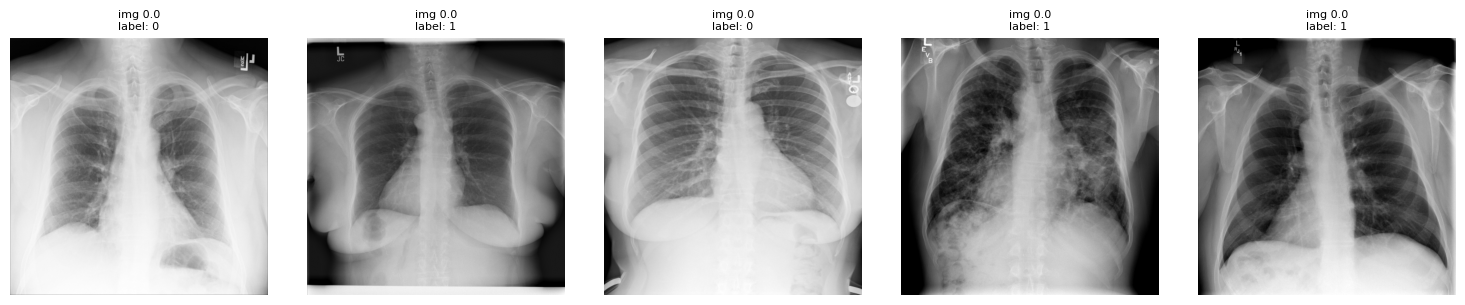

2025-04-13 03:59:02.386085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7674 of 8000
2025-04-13 03:59:02.619888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-13 03:59:02.667978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


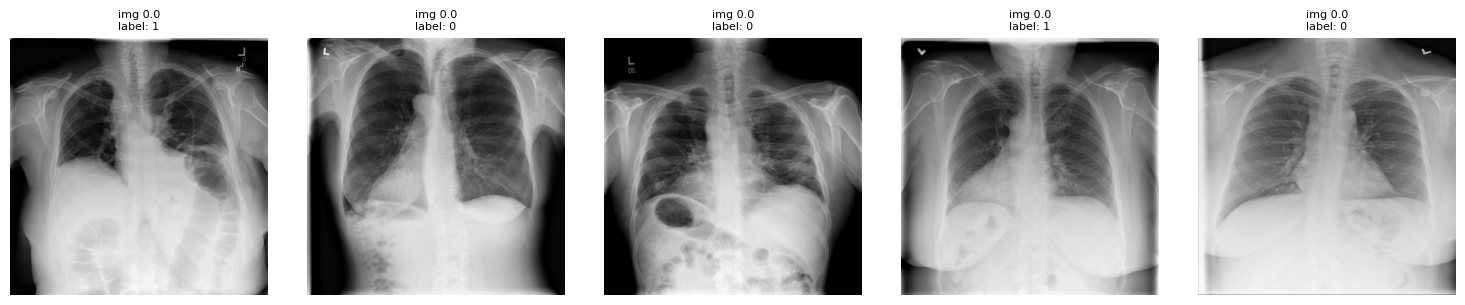

2025-04-13 03:59:13.284733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7198 of 8000
2025-04-13 03:59:14.219948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-13 03:59:14.273627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


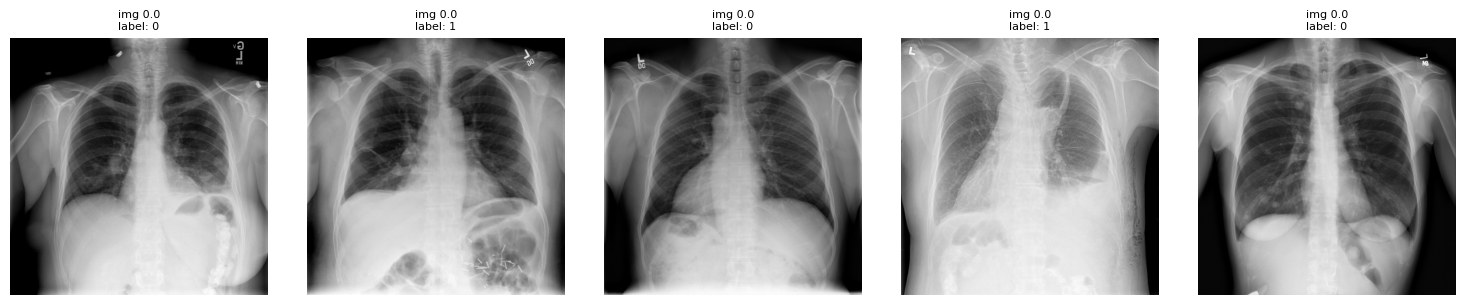

2025-04-13 03:59:24.884849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7650 of 8000
2025-04-13 03:59:25.224586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-13 03:59:25.318430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


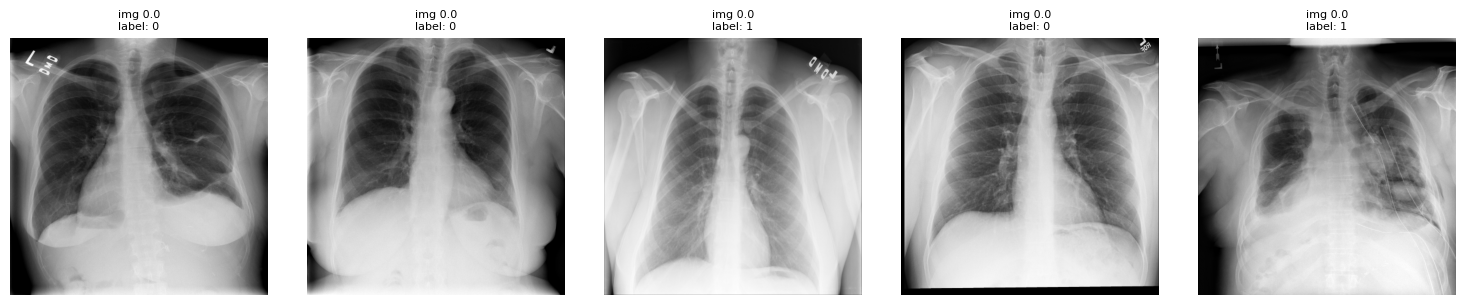

2025-04-13 03:59:28.761856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


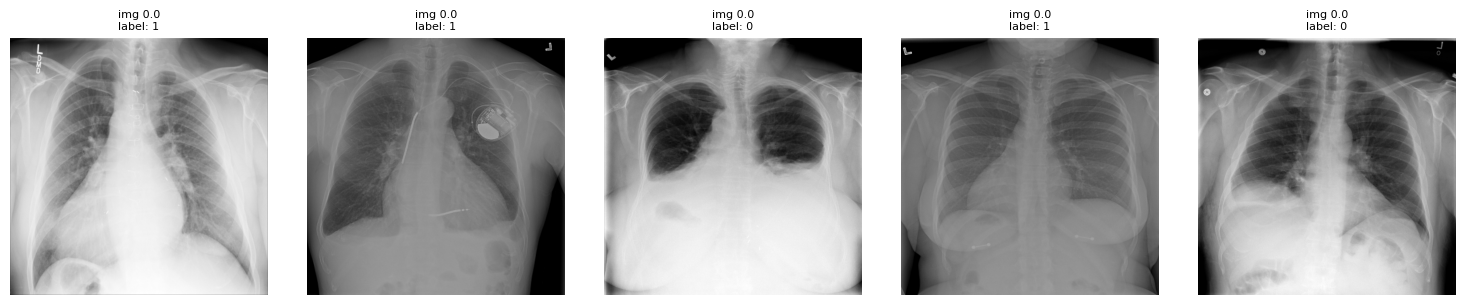

2025-04-13 03:59:29.753271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


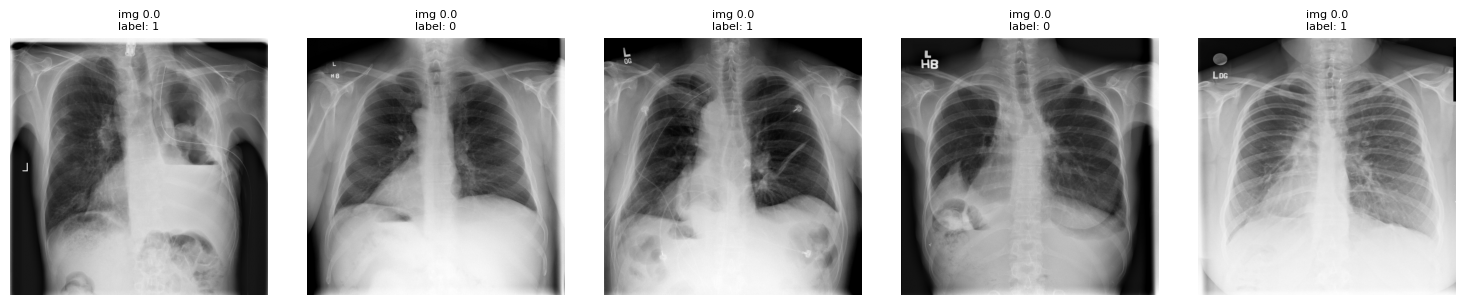

2025-04-13 03:59:40.075718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


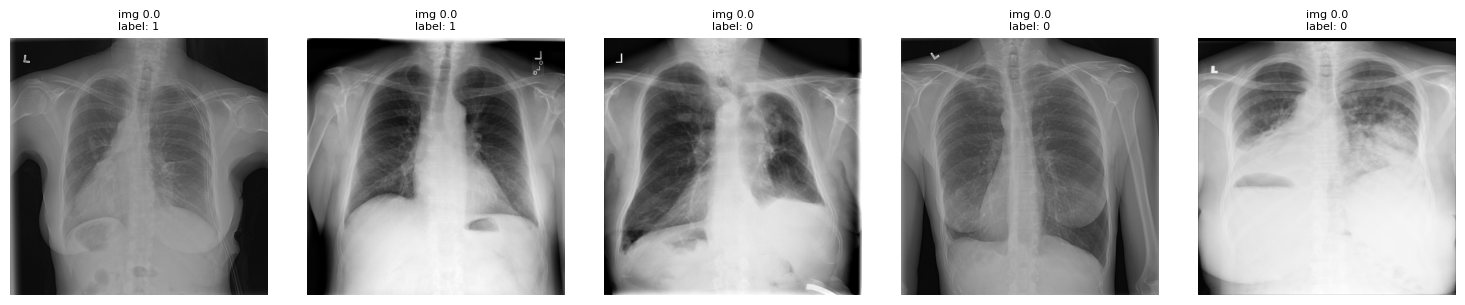

In [366]:
def show_first_images(ds, n=5):
    """
    Display the first *n* images contained in `image_input`
    of a `tf.data.Dataset` whose elements look like
        ({"image_input": <tensor>, ...}, label)   # or
        {"image_input": <tensor>, ...}            # if unlabeled
    """
    plt.figure(figsize=(3 * n, 3))

    for i, sample in enumerate(ds.unbatch().take(n)):
        # Handle both (inputs, label) and inputs‑only cases
        if isinstance(sample, tuple):
            inputs, label = sample
        else:
            inputs, label = sample, None

        img = inputs["image_input"]            # (H, W, C) float or uint8
        debug = inputs["input_debug"]

        # Tensor → NumPy for matplotlib
        img_np = img.numpy()

        # Squeeze the channel dim if it’s single‑channel
        if img_np.shape[-1] == 1:
            img_np = img_np.squeeze(-1)
            cmap = "gray"
        else:
            cmap = None                        # default = RGB

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np, cmap=cmap)
        plt.axis("off")
        
        title = f"img {debug}"
        if label is not None:
            # label could be tensor → convert to Python scalar / list
            label_val = label.numpy()
            # Flatten to plain int/float if possible
            if label_val.size == 1:
                label_val = label_val.item()
            title += f"\nlabel: {label_val}"
        plt.title(title, fontsize=8)

    plt.tight_layout()
    plt.show()

for i, (train_ds, val_ds, _) in enumerate(tasks_datasets):
    show_first_images(train_ds)

## Model Training

In [367]:
# Save the history to a JSON file
def save_history(history, filename):
    with open(filename, 'w') as f:
        json.dump(history.history, f)

# Load the history from a JSON file
def load_history(filename):
    with open(filename, 'r') as f:
        history = json.load(f)
    return history

In [368]:
import math
EPOCHS=40
AUC_PATIENCE_FACTOR = 4
AUC_PATIENCE=math.ceil(EPOCHS/AUC_PATIENCE_FACTOR)
LR_PATIENCE=math.ceil(EPOCHS/10)
LR_PATIENCE=3
print(f"{EPOCHS=} {AUC_PATIENCE=} {LR_PATIENCE=}")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # monitor='val_auc',
        monitor='val_loss',
        patience=AUC_PATIENCE,
        # mode='max',
        restore_best_weights=True,
        # min_delta=1e-4,       # ignore <0.0001 change
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        # monitor='val_auc',
        monitor='val_loss',
        factor=0.5,
        patience=LR_PATIENCE,
        min_lr=1e-6
    )
]



all_models = []
for i, (train_ds, val_ds, _) in enumerate(tasks_datasets):
    # Create and train the model
    # Get the number of tabular features using X_train_tab.shape[1]
    # print(X_train_tab.shape[1])
    # break
    num_tabular_features = 3
    model = create_hybrid_model_v1(num_tabular_features)

    LOAD_FROM_FILE_DONT_TRAIN = False
    model_path   = os.path.join(DRIVE_PATH, f'model_{i+1}.keras')
    history_path = os.path.join(DRIVE_PATH, f'model_{i+1}_history.json')

    if LOAD_FROM_FILE_DONT_TRAIN:
        model = tf.keras.models.load_model(model_path)
        history = load_history(history_path)
        print(f"Model {i+1} LOADED from file {model_path} and {history_path}")
    else:
        history = model.fit(
            train_ds, 
            epochs=EPOCHS, 
            validation_data=val_ds, 
            callbacks=callbacks
        )
        print(f"Model {i+1} trained successfully")

        model.save(model_path)
        save_history(history, history_path)
        print(f"Saved to keras file {model_path} and {history_path}")

    all_models.append( (model, history) )

EPOCHS=40 AUC_PATIENCE=10 LR_PATIENCE=3
Epoch 1/40


2025-04-13 03:59:57.186632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7340 of 8000
2025-04-13 03:59:57.908665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.5153 - auc: 0.5197 - bin_accuracy: 0.5153 - loss: 3.5455 - precision: 0.5221 - recall: 0.5209 - val_accuracy: 0.4930 - val_auc: 0.5313 - val_bin_accuracy: 0.4930 - val_loss: 2.6505 - val_precision: 0.5263 - val_recall: 0.1934 - learning_rate: 1.0000e-04
Epoch 2/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.5781 - auc: 0.5936 - bin_accuracy: 0.5781 - loss: 2.6240 - precision: 0.5000 - recall: 0.5934   

2025-04-13 04:00:55.684448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7814 of 8000
2025-04-13 04:00:55.717907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5259 - auc: 0.5353 - bin_accuracy: 0.5259 - loss: 2.4493 - precision: 0.5252 - recall: 0.5379 - val_accuracy: 0.5270 - val_auc: 0.5734 - val_bin_accuracy: 0.5270 - val_loss: 1.9270 - val_precision: 0.6279 - val_recall: 0.2089 - learning_rate: 1.0000e-04
Epoch 3/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:25:32 10s/step - accuracy: 0.6250 - auc: 0.6429 - bin_accuracy: 0.6250 - loss: 1.9023 - precision: 0.6364 - recall: 0.7778

2025-04-13 04:01:37.199411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7749 of 8000
2025-04-13 04:01:37.326302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5245 - auc: 0.5288 - bin_accuracy: 0.5245 - loss: 1.8032 - precision: 0.5226 - recall: 0.5348 - val_accuracy: 0.5540 - val_auc: 0.5723 - val_bin_accuracy: 0.5540 - val_loss: 1.4640 - val_precision: 0.5709 - val_recall: 0.5532 - learning_rate: 1.0000e-04
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5323 - auc: 0.5490 - bin_accuracy: 0.5323 - loss: 1.3863 - precision: 0.5315 - recall: 0.5465 - val_accuracy: 0.5440 - val_auc: 0.5732 - val_bin_accuracy: 0.5440 - val_loss: 1.1741 - val_precision: 0.6034 - val_recall: 0.3443 - learning_rate: 1.0000e-04
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5543 - auc: 0.5722 - bin_accuracy: 0.5543 - loss: 1.1191 - precision: 0.5536 - recall: 0.5952 - val_accuracy: 0.5450 - val_auc: 0.5635 - val_bin_accuracy: 0.5450 - val_loss: 0.9891 - val_precision: 0.5560 - val_recall: 0.5957 - learning_rate: 1.0000e-04
Epoch 6/40


2025-04-13 04:03:41.406486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7433 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.4097 - auc: 0.4057 - bin_accuracy: 0.4097 - loss: 1.0034 - precision: 0.6635 - recall: 0.4454

2025-04-13 04:03:41.917129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5445 - auc: 0.5592 - bin_accuracy: 0.5445 - loss: 0.9562 - precision: 0.5464 - recall: 0.5874 - val_accuracy: 0.5530 - val_auc: 0.5700 - val_bin_accuracy: 0.5530 - val_loss: 0.8730 - val_precision: 0.5792 - val_recall: 0.4952 - learning_rate: 1.0000e-04
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5430 - auc: 0.5535 - bin_accuracy: 0.5430 - loss: 0.8553 - precision: 0.5382 - recall: 0.5591 - val_accuracy: 0.5440 - val_auc: 0.5701 - val_bin_accuracy: 0.5440 - val_loss: 0.8042 - val_precision: 0.5836 - val_recall: 0.4120 - learning_rate: 1.0000e-04
Epoch 8/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.4688 - auc: 0.6508 - bin_accuracy: 0.4688 - loss: 0.7786 - precision: 0.5714 - recall: 0.4222   

2025-04-13 04:05:04.489831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7909 of 8000
2025-04-13 04:05:04.522255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5439 - auc: 0.5659 - bin_accuracy: 0.5439 - loss: 0.7898 - precision: 0.5414 - recall: 0.5921 - val_accuracy: 0.5530 - val_auc: 0.5745 - val_bin_accuracy: 0.5530 - val_loss: 0.7593 - val_precision: 0.5518 - val_recall: 0.7215 - learning_rate: 1.0000e-04
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5385 - auc: 0.5581 - bin_accuracy: 0.5385 - loss: 0.7548 - precision: 0.5321 - recall: 0.5759 - val_accuracy: 0.5420 - val_auc: 0.5752 - val_bin_accuracy: 0.5420 - val_loss: 0.7350 - val_precision: 0.5448 - val_recall: 0.6944 - learning_rate: 1.0000e-04
Epoch 10/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5516 - auc: 0.5689 - bin_accuracy: 0.5516 - loss: 0.7307 - precision: 0.5410 - recall: 0.6471 - val_accuracy: 0.5520 - val_auc: 0.5728 - val_bin_accuracy: 0.5520 - val_loss: 0.7212 - val_precision: 0.5714 - val_recall: 0.5338 - learning_rate: 1.0000e-04
Epoch 11/40


2025-04-13 04:07:08.887585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7630 of 8000


  2/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6094 - auc: 0.6886 - bin_accuracy: 0.6094 - loss: 0.7089 - precision: 0.4605 - recall: 0.8167   

2025-04-13 04:07:09.125459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5547 - auc: 0.5696 - bin_accuracy: 0.5547 - loss: 0.7177 - precision: 0.5456 - recall: 0.5951 - val_accuracy: 0.5450 - val_auc: 0.5711 - val_bin_accuracy: 0.5450 - val_loss: 0.7110 - val_precision: 0.5468 - val_recall: 0.7002 - learning_rate: 1.0000e-04
Epoch 12/40


2025-04-13 04:07:50.792295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7641 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.3576 - auc: 0.3960 - bin_accuracy: 0.3576 - loss: 0.7347 - precision: 0.3615 - recall: 0.4670

2025-04-13 04:07:51.109599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5520 - auc: 0.5674 - bin_accuracy: 0.5520 - loss: 0.7090 - precision: 0.5458 - recall: 0.6735 - val_accuracy: 0.5350 - val_auc: 0.5687 - val_bin_accuracy: 0.5350 - val_loss: 0.7084 - val_precision: 0.5747 - val_recall: 0.3868 - learning_rate: 1.0000e-04
Epoch 13/40


2025-04-13 04:08:32.386082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7589 of 8000


  2/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.4375 - auc: 0.3764 - bin_accuracy: 0.4375 - loss: 0.7300 - precision: 0.3214 - recall: 0.3512   

2025-04-13 04:08:32.629574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5468 - auc: 0.5665 - bin_accuracy: 0.5468 - loss: 0.7043 - precision: 0.5398 - recall: 0.5714 - val_accuracy: 0.5200 - val_auc: 0.5651 - val_bin_accuracy: 0.5200 - val_loss: 0.7134 - val_precision: 0.5939 - val_recall: 0.2263 - learning_rate: 1.0000e-04
Epoch 14/40


2025-04-13 04:09:14.192594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7557 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.5278 - auc: 0.6647 - bin_accuracy: 0.5278 - loss: 0.6758 - precision: 0.5796 - recall: 0.6008

2025-04-13 04:09:14.623948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5489 - auc: 0.5696 - bin_accuracy: 0.5489 - loss: 0.6995 - precision: 0.5411 - recall: 0.6500 - val_accuracy: 0.5500 - val_auc: 0.5761 - val_bin_accuracy: 0.5500 - val_loss: 0.6969 - val_precision: 0.5466 - val_recall: 0.7602 - learning_rate: 1.0000e-04
Epoch 15/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.4062 - auc: 0.4245 - bin_accuracy: 0.4062 - loss: 0.7222 - precision: 0.3985 - recall: 0.4359   

2025-04-13 04:09:56.197606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7888 of 8000
2025-04-13 04:09:56.223410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5593 - auc: 0.5733 - bin_accuracy: 0.5593 - loss: 0.6986 - precision: 0.5510 - recall: 0.6152 - val_accuracy: 0.5310 - val_auc: 0.5743 - val_bin_accuracy: 0.5310 - val_loss: 0.6993 - val_precision: 0.5863 - val_recall: 0.3153 - learning_rate: 1.0000e-04
Epoch 16/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.5312 - auc: 0.4127 - bin_accuracy: 0.5312 - loss: 0.7279 - precision: 0.5714 - recall: 0.6333   

2025-04-13 04:10:37.886982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7770 of 8000
2025-04-13 04:10:37.931794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5486 - auc: 0.5715 - bin_accuracy: 0.5486 - loss: 0.6942 - precision: 0.5372 - recall: 0.6466 - val_accuracy: 0.5290 - val_auc: 0.5630 - val_bin_accuracy: 0.5290 - val_loss: 0.7030 - val_precision: 0.5966 - val_recall: 0.2747 - learning_rate: 1.0000e-04
Epoch 17/40


2025-04-13 04:11:19.304663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7344 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.5868 - auc: 0.5884 - bin_accuracy: 0.5868 - loss: 0.6989 - precision: 0.5988 - recall: 0.6408

2025-04-13 04:11:20.010237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5482 - auc: 0.5745 - bin_accuracy: 0.5482 - loss: 0.6930 - precision: 0.5426 - recall: 0.6348 - val_accuracy: 0.5400 - val_auc: 0.5722 - val_bin_accuracy: 0.5400 - val_loss: 0.6933 - val_precision: 0.5391 - val_recall: 0.7602 - learning_rate: 1.0000e-04
Epoch 18/40


2025-04-13 04:12:01.586474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7474 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.4653 - auc: 0.4990 - bin_accuracy: 0.4653 - loss: 0.6895 - precision: 0.4815 - recall: 0.5739

2025-04-13 04:12:02.119699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5486 - auc: 0.5734 - bin_accuracy: 0.5486 - loss: 0.6911 - precision: 0.5390 - recall: 0.6904 - val_accuracy: 0.5450 - val_auc: 0.5767 - val_bin_accuracy: 0.5450 - val_loss: 0.6924 - val_precision: 0.5518 - val_recall: 0.6383 - learning_rate: 1.0000e-04
Epoch 19/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5508 - auc: 0.5729 - bin_accuracy: 0.5508 - loss: 0.6896 - precision: 0.5452 - recall: 0.6794 - val_accuracy: 0.5550 - val_auc: 0.5709 - val_bin_accuracy: 0.5550 - val_loss: 0.6944 - val_precision: 0.5700 - val_recall: 0.5667 - learning_rate: 1.0000e-04
Epoch 20/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5641 - auc: 0.5841 - bin_accuracy: 0.5641 - loss: 0.6880 - precision: 0.5514 - recall: 0.6724 - val_accuracy: 0.5440 - val_auc: 0.5675 - val_bin_accuracy: 0.5440 - val_loss: 0.6946 - val_precision: 0.5749 - val_recall: 0.4526 - learning_rate: 1.0000e-04
Epoch 21/40


2025-04-13 04:14:05.784490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7711 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.5069 - auc: 0.4921 - bin_accuracy: 0.5069 - loss: 0.7089 - precision: 0.5662 - recall: 0.7064

2025-04-13 04:14:06.028262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5632 - auc: 0.5818 - bin_accuracy: 0.5632 - loss: 0.6886 - precision: 0.5498 - recall: 0.7149 - val_accuracy: 0.5370 - val_auc: 0.5755 - val_bin_accuracy: 0.5370 - val_loss: 0.6901 - val_precision: 0.5390 - val_recall: 0.7215 - learning_rate: 1.0000e-04
Epoch 22/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:26:17 10s/step - accuracy: 0.3750 - auc: 0.3175 - bin_accuracy: 0.3750 - loss: 0.6999 - precision: 0.3333 - recall: 0.4286

2025-04-13 04:14:47.388809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7752 of 8000
2025-04-13 04:14:47.523829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5495 - auc: 0.5756 - bin_accuracy: 0.5495 - loss: 0.6873 - precision: 0.5415 - recall: 0.6679 - val_accuracy: 0.5550 - val_auc: 0.5778 - val_bin_accuracy: 0.5550 - val_loss: 0.6902 - val_precision: 0.5465 - val_recall: 0.8182 - learning_rate: 1.0000e-04
Epoch 23/40


2025-04-13 04:15:28.985496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7603 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.5000 - auc: 0.4986 - bin_accuracy: 0.5000 - loss: 0.7163 - precision: 0.5873 - recall: 0.4272

2025-04-13 04:15:29.303164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5417 - auc: 0.5611 - bin_accuracy: 0.5417 - loss: 0.6905 - precision: 0.5322 - recall: 0.6353 - val_accuracy: 0.5330 - val_auc: 0.5690 - val_bin_accuracy: 0.5330 - val_loss: 0.6919 - val_precision: 0.5317 - val_recall: 0.8104 - learning_rate: 1.0000e-04
Epoch 24/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5492 - auc: 0.5683 - bin_accuracy: 0.5492 - loss: 0.6893 - precision: 0.5361 - recall: 0.6265 - val_accuracy: 0.5590 - val_auc: 0.5749 - val_bin_accuracy: 0.5590 - val_loss: 0.6896 - val_precision: 0.5766 - val_recall: 0.5532 - learning_rate: 1.0000e-04
Epoch 25/40


2025-04-13 04:16:52.287635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7398 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.6736 - auc: 0.6660 - bin_accuracy: 0.6736 - loss: 0.6691 - precision: 0.6597 - recall: 0.8692

2025-04-13 04:16:52.810081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5586 - auc: 0.5772 - bin_accuracy: 0.5586 - loss: 0.6868 - precision: 0.5510 - recall: 0.6843 - val_accuracy: 0.5650 - val_auc: 0.5810 - val_bin_accuracy: 0.5650 - val_loss: 0.6887 - val_precision: 0.5697 - val_recall: 0.6480 - learning_rate: 1.0000e-04
Epoch 26/40


2025-04-13 04:17:34.489855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7336 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6111 - auc: 0.6698 - bin_accuracy: 0.6111 - loss: 0.6921 - precision: 0.5910 - recall: 0.6598

2025-04-13 04:17:35.204351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5653 - auc: 0.5805 - bin_accuracy: 0.5653 - loss: 0.6878 - precision: 0.5603 - recall: 0.6917 - val_accuracy: 0.5410 - val_auc: 0.5711 - val_bin_accuracy: 0.5410 - val_loss: 0.6902 - val_precision: 0.5428 - val_recall: 0.7118 - learning_rate: 1.0000e-04
Epoch 27/40


2025-04-13 04:18:16.586043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7646 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.5521 - auc: 0.6184 - bin_accuracy: 0.5521 - loss: 0.6804 - precision: 0.6902 - recall: 0.5349

2025-04-13 04:18:16.824492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5610 - auc: 0.5853 - bin_accuracy: 0.5610 - loss: 0.6849 - precision: 0.5616 - recall: 0.6468 - val_accuracy: 0.5460 - val_auc: 0.5740 - val_bin_accuracy: 0.5460 - val_loss: 0.6897 - val_precision: 0.5417 - val_recall: 0.7911 - learning_rate: 1.0000e-04
Epoch 28/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5463 - auc: 0.5786 - bin_accuracy: 0.5463 - loss: 0.6855 - precision: 0.5296 - recall: 0.6192 - val_accuracy: 0.5550 - val_auc: 0.5820 - val_bin_accuracy: 0.5550 - val_loss: 0.6874 - val_precision: 0.5503 - val_recall: 0.7621 - learning_rate: 1.0000e-04
Epoch 29/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5711 - auc: 0.5948 - bin_accuracy: 0.5711 - loss: 0.6816 - precision: 0.5554 - recall: 0.7061 - val_accuracy: 0.5580 - val_auc: 0.5795 - val_bin_accuracy: 0.5580 - val_loss: 0.6874 - val_precision: 0.5626 - val_recall: 0.6518 - learning_rate: 1.0000e-04
Epoch 30/40


2025-04-13 04:20:19.598071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7692 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.5660 - auc: 0.5294 - bin_accuracy: 0.5660 - loss: 0.6956 - precision: 0.5192 - recall: 0.5079

2025-04-13 04:20:19.810173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5713 - auc: 0.5856 - bin_accuracy: 0.5713 - loss: 0.6855 - precision: 0.5686 - recall: 0.6744 - val_accuracy: 0.5510 - val_auc: 0.5788 - val_bin_accuracy: 0.5510 - val_loss: 0.6894 - val_precision: 0.5705 - val_recall: 0.5319 - learning_rate: 1.0000e-04
Epoch 31/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5563 - auc: 0.5836 - bin_accuracy: 0.5563 - loss: 0.6858 - precision: 0.5509 - recall: 0.6370 - val_accuracy: 0.5610 - val_auc: 0.5885 - val_bin_accuracy: 0.5610 - val_loss: 0.6862 - val_precision: 0.5552 - val_recall: 0.7582 - learning_rate: 1.0000e-04
Epoch 32/40


2025-04-13 04:21:42.484448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7067 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7292 - auc: 0.7394 - bin_accuracy: 0.7292 - loss: 0.6786 - precision: 0.8889 - recall: 0.6527

2025-04-13 04:21:43.518936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.5587 - auc: 0.5836 - bin_accuracy: 0.5587 - loss: 0.6863 - precision: 0.5534 - recall: 0.6499 - val_accuracy: 0.5140 - val_auc: 0.5658 - val_bin_accuracy: 0.5140 - val_loss: 0.7154 - val_precision: 0.5756 - val_recall: 0.2282 - learning_rate: 1.0000e-04
Epoch 33/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:25:28 10s/step - accuracy: 0.6250 - auc: 0.5635 - bin_accuracy: 0.6250 - loss: 0.7021 - precision: 0.6667 - recall: 0.6667

2025-04-13 04:22:24.988601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7778 of 8000
2025-04-13 04:22:25.107655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5615 - auc: 0.5769 - bin_accuracy: 0.5615 - loss: 0.6870 - precision: 0.5529 - recall: 0.6561 - val_accuracy: 0.5670 - val_auc: 0.5852 - val_bin_accuracy: 0.5670 - val_loss: 0.6873 - val_precision: 0.5580 - val_recall: 0.7814 - learning_rate: 1.0000e-04
Epoch 34/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5507 - auc: 0.5745 - bin_accuracy: 0.5507 - loss: 0.6856 - precision: 0.5369 - recall: 0.6473 - val_accuracy: 0.5510 - val_auc: 0.5850 - val_bin_accuracy: 0.5510 - val_loss: 0.6850 - val_precision: 0.5702 - val_recall: 0.5338 - learning_rate: 1.0000e-04
Epoch 35/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5565 - auc: 0.5838 - bin_accuracy: 0.5565 - loss: 0.6840 - precision: 0.5450 - recall: 0.6660 - val_accuracy: 0.5550 - val_auc: 0.5828 - val_bin_accuracy: 0.5550 - val_loss: 0.6862 - val_precision: 0.5744 - val_recall: 0.5377 - learning_rate: 1.0000e-04
Epoch 36/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:

2025-04-13 04:24:29.005057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7845 of 8000
2025-04-13 04:24:29.091734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5653 - auc: 0.5972 - bin_accuracy: 0.5653 - loss: 0.6798 - precision: 0.5482 - recall: 0.6355 - val_accuracy: 0.5530 - val_auc: 0.5841 - val_bin_accuracy: 0.5530 - val_loss: 0.6854 - val_precision: 0.5543 - val_recall: 0.6905 - learning_rate: 1.0000e-04
Epoch 37/40


2025-04-13 04:25:10.496472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7623 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.5417 - auc: 0.5288 - bin_accuracy: 0.5417 - loss: 0.6981 - precision: 0.5210 - recall: 0.6730

2025-04-13 04:25:10.913244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5661 - auc: 0.5868 - bin_accuracy: 0.5661 - loss: 0.6847 - precision: 0.5540 - recall: 0.7116 - val_accuracy: 0.5330 - val_auc: 0.5701 - val_bin_accuracy: 0.5330 - val_loss: 0.6974 - val_precision: 0.5714 - val_recall: 0.3868 - learning_rate: 1.0000e-04
Epoch 38/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:25:19 10s/step - accuracy: 0.6250 - auc: 0.5859 - bin_accuracy: 0.6250 - loss: 0.6925 - precision: 0.6250 - recall: 0.6250

2025-04-13 04:25:52.307347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7894 of 8000
2025-04-13 04:25:52.413268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5706 - auc: 0.5981 - bin_accuracy: 0.5706 - loss: 0.6815 - precision: 0.5537 - recall: 0.6898 - val_accuracy: 0.5730 - val_auc: 0.5956 - val_bin_accuracy: 0.5730 - val_loss: 0.6839 - val_precision: 0.5620 - val_recall: 0.7892 - learning_rate: 5.0000e-05
Epoch 39/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5715 - auc: 0.5972 - bin_accuracy: 0.5715 - loss: 0.6799 - precision: 0.5574 - recall: 0.7099 - val_accuracy: 0.5550 - val_auc: 0.5847 - val_bin_accuracy: 0.5550 - val_loss: 0.6850 - val_precision: 0.5541 - val_recall: 0.7137 - learning_rate: 5.0000e-05
Epoch 40/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.5781 - auc: 0.6621 - bin_accuracy: 0.5781 - loss: 0.6457 - precision: 0.5632 - recall: 0.6875   

2025-04-13 04:27:15.084711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53358: Filling up shuffle buffer (this may take a while): 7802 of 8000
2025-04-13 04:27:15.134693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5712 - auc: 0.6020 - bin_accuracy: 0.5712 - loss: 0.6787 - precision: 0.5619 - recall: 0.6746 - val_accuracy: 0.5520 - val_auc: 0.5818 - val_bin_accuracy: 0.5520 - val_loss: 0.6869 - val_precision: 0.5647 - val_recall: 0.5822 - learning_rate: 5.0000e-05
Model 1 trained successfully
Saved to keras file /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_1.keras and /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_1_history.json
Epoch 1/40


2025-04-13 04:28:03.085792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7424 of 8000
2025-04-13 04:28:03.621797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.5261 - auc: 0.5306 - bin_accuracy: 0.5261 - loss: 3.5267 - precision: 0.5261 - recall: 0.4414 - val_accuracy: 0.6110 - val_auc: 0.6539 - val_bin_accuracy: 0.6110 - val_loss: 2.5708 - val_precision: 0.5930 - val_recall: 0.7892 - learning_rate: 1.0000e-04
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5870 - auc: 0.6299 - bin_accuracy: 0.5870 - loss: 2.3599 - precision: 0.5938 - recall: 0.5662 - val_accuracy: 0.6080 - val_auc: 0.6654 - val_bin_accuracy: 0.6080 - val_loss: 1.8209 - val_precision: 0.6181 - val_recall: 0.6325 - learning_rate: 1.0000e-04
Epoch 3/40


2025-04-13 04:29:42.787078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7511 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.4410 - auc: 0.4606 - bin_accuracy: 0.4410 - loss: 1.9114 - precision: 0.4640 - recall: 0.4303

2025-04-13 04:29:43.332852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6146 - auc: 0.6444 - bin_accuracy: 0.6146 - loss: 1.7005 - precision: 0.6152 - recall: 0.5868 - val_accuracy: 0.6130 - val_auc: 0.6757 - val_bin_accuracy: 0.6130 - val_loss: 1.3762 - val_precision: 0.5923 - val_recall: 0.8066 - learning_rate: 1.0000e-04
Epoch 4/40


2025-04-13 04:30:24.793782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7535 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6215 - auc: 0.6581 - bin_accuracy: 0.6215 - loss: 1.3809 - precision: 0.6379 - recall: 0.6799

2025-04-13 04:30:25.212178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6251 - auc: 0.6662 - bin_accuracy: 0.6251 - loss: 1.2952 - precision: 0.6356 - recall: 0.6159 - val_accuracy: 0.6160 - val_auc: 0.6883 - val_bin_accuracy: 0.6160 - val_loss: 1.1142 - val_precision: 0.7125 - val_recall: 0.4313 - learning_rate: 1.0000e-04
Epoch 5/40


2025-04-13 04:31:06.685108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7678 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.5556 - auc: 0.7304 - bin_accuracy: 0.5556 - loss: 1.0721 - precision: 0.6710 - recall: 0.4542

2025-04-13 04:31:06.927639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6319 - auc: 0.6818 - bin_accuracy: 0.6319 - loss: 1.0485 - precision: 0.6346 - recall: 0.6033 - val_accuracy: 0.6390 - val_auc: 0.6874 - val_bin_accuracy: 0.6390 - val_loss: 0.9329 - val_precision: 0.6718 - val_recall: 0.5899 - learning_rate: 1.0000e-04
Epoch 6/40


2025-04-13 04:31:48.489370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7471 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6701 - auc: 0.7123 - bin_accuracy: 0.6701 - loss: 0.9164 - precision: 0.7468 - recall: 0.6290

2025-04-13 04:31:48.939325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6475 - auc: 0.6998 - bin_accuracy: 0.6475 - loss: 0.8922 - precision: 0.6495 - recall: 0.6396 - val_accuracy: 0.6590 - val_auc: 0.7063 - val_bin_accuracy: 0.6590 - val_loss: 0.8165 - val_precision: 0.6492 - val_recall: 0.7408 - learning_rate: 1.0000e-04
Epoch 7/40


2025-04-13 04:32:30.487078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7698 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.8021 - auc: 0.8216 - bin_accuracy: 0.8021 - loss: 0.7756 - precision: 0.6991 - recall: 0.8694

2025-04-13 04:32:30.721189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6637 - auc: 0.7121 - bin_accuracy: 0.6637 - loss: 0.7949 - precision: 0.6669 - recall: 0.6835 - val_accuracy: 0.4990 - val_auc: 0.6916 - val_bin_accuracy: 0.4990 - val_loss: 0.9768 - val_precision: 0.8333 - val_recall: 0.0387 - learning_rate: 1.0000e-04
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6531 - auc: 0.6974 - bin_accuracy: 0.6531 - loss: 0.7484 - precision: 0.6596 - recall: 0.6624 - val_accuracy: 0.6580 - val_auc: 0.7162 - val_bin_accuracy: 0.6580 - val_loss: 0.7078 - val_precision: 0.6636 - val_recall: 0.6867 - learning_rate: 1.0000e-04
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6617 - auc: 0.7143 - bin_accuracy: 0.6617 - loss: 0.7041 - precision: 0.6665 - recall: 0.6751 - val_accuracy: 0.6510 - val_auc: 0.7135 - val_bin_accuracy: 0.6510 - val_loss: 0.6959 - val_precision: 0.6935 - val_recall: 0.5822 - learning_rate: 1.0000e-04
Epoch 10/40


2025-04-13 04:34:34.985924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7477 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.7535 - auc: 0.8269 - bin_accuracy: 0.7535 - loss: 0.6249 - precision: 0.7016 - recall: 0.8111

2025-04-13 04:34:35.521030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6666 - auc: 0.7225 - bin_accuracy: 0.6666 - loss: 0.6766 - precision: 0.6611 - recall: 0.6779 - val_accuracy: 0.6650 - val_auc: 0.7131 - val_bin_accuracy: 0.6650 - val_loss: 0.6750 - val_precision: 0.6417 - val_recall: 0.7969 - learning_rate: 1.0000e-04
Epoch 11/40


2025-04-13 04:35:17.084738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7285 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.7083 - auc: 0.8824 - bin_accuracy: 0.7083 - loss: 0.5905 - precision: 0.5787 - recall: 0.8333

2025-04-13 04:35:17.807511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6737 - auc: 0.7330 - bin_accuracy: 0.6737 - loss: 0.6562 - precision: 0.6596 - recall: 0.6902 - val_accuracy: 0.6450 - val_auc: 0.7132 - val_bin_accuracy: 0.6450 - val_loss: 0.6793 - val_precision: 0.7056 - val_recall: 0.5377 - learning_rate: 1.0000e-04
Epoch 12/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6869 - auc: 0.7434 - bin_accuracy: 0.6869 - loss: 0.6381 - precision: 0.6815 - recall: 0.7059 - val_accuracy: 0.4830 - val_auc: 0.5880 - val_bin_accuracy: 0.4830 - val_loss: 1.7560 - val_precision: 0.5000 - val_recall: 0.0116 - learning_rate: 1.0000e-04
Epoch 13/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6962 - auc: 0.7528 - bin_accuracy: 0.6962 - loss: 0.6250 - precision: 0.6892 - recall: 0.6815 - val_accuracy: 0.4970 - val_auc: 0.7300 - val_bin_accuracy: 0.4970 - val_loss: 1.0843 - val_precision: 0.9375 - val_recall: 0.0290 - learning_rate: 1.0000e-04
Epoch 14/40


2025-04-13 04:37:22.184767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7727 of 8000
2025-04-13 04:37:22.327864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7037 - auc: 0.7629 - bin_accuracy: 0.7037 - loss: 0.6109 - precision: 0.7020 - recall: 0.7228 - val_accuracy: 0.6960 - val_auc: 0.7563 - val_bin_accuracy: 0.6960 - val_loss: 0.6222 - val_precision: 0.6885 - val_recall: 0.7524 - learning_rate: 5.0000e-05
Epoch 15/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7073 - auc: 0.7713 - bin_accuracy: 0.7073 - loss: 0.6011 - precision: 0.7094 - recall: 0.6917 - val_accuracy: 0.6910 - val_auc: 0.7598 - val_bin_accuracy: 0.6910 - val_loss: 0.6348 - val_precision: 0.7353 - val_recall: 0.6286 - learning_rate: 5.0000e-05
Epoch 16/40


2025-04-13 04:38:44.984699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7650 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7431 - auc: 0.7720 - bin_accuracy: 0.7431 - loss: 0.5937 - precision: 0.7302 - recall: 0.7345

2025-04-13 04:38:45.207489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7111 - auc: 0.7738 - bin_accuracy: 0.7111 - loss: 0.5974 - precision: 0.7128 - recall: 0.7017 - val_accuracy: 0.6090 - val_auc: 0.7133 - val_bin_accuracy: 0.6090 - val_loss: 0.7650 - val_precision: 0.7480 - val_recall: 0.3675 - learning_rate: 5.0000e-05
Epoch 17/40


2025-04-13 04:39:26.698629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7336 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.7083 - auc: 0.8132 - bin_accuracy: 0.7083 - loss: 0.5851 - precision: 0.6069 - recall: 0.7980

2025-04-13 04:39:27.515106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7203 - auc: 0.7851 - bin_accuracy: 0.7203 - loss: 0.5877 - precision: 0.7152 - recall: 0.7231 - val_accuracy: 0.6340 - val_auc: 0.7425 - val_bin_accuracy: 0.6340 - val_loss: 0.7701 - val_precision: 0.6005 - val_recall: 0.8723 - learning_rate: 5.0000e-05
Epoch 18/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7812 - auc: 0.7310 - bin_accuracy: 0.7812 - loss: 0.5927 - precision: 0.7411 - recall: 0.7917   

2025-04-13 04:40:08.884827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7810 of 8000
2025-04-13 04:40:08.925697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7339 - auc: 0.7956 - bin_accuracy: 0.7339 - loss: 0.5735 - precision: 0.7299 - recall: 0.7317 - val_accuracy: 0.6680 - val_auc: 0.7685 - val_bin_accuracy: 0.6680 - val_loss: 0.6679 - val_precision: 0.6316 - val_recall: 0.8588 - learning_rate: 2.5000e-05
Epoch 19/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:25:21 10s/step - accuracy: 0.7500 - auc: 0.7656 - bin_accuracy: 0.7500 - loss: 0.6027 - precision: 0.7500 - recall: 0.7500

2025-04-13 04:40:50.508352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7897 of 8000
2025-04-13 04:40:50.600357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7282 - auc: 0.7973 - bin_accuracy: 0.7282 - loss: 0.5724 - precision: 0.7276 - recall: 0.7246 - val_accuracy: 0.7000 - val_auc: 0.7751 - val_bin_accuracy: 0.7000 - val_loss: 0.6377 - val_precision: 0.6667 - val_recall: 0.8395 - learning_rate: 2.5000e-05
Epoch 20/40


2025-04-13 04:41:32.284680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7705 of 8000
2025-04-13 04:41:32.422846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7320 - auc: 0.7971 - bin_accuracy: 0.7320 - loss: 0.5714 - precision: 0.7210 - recall: 0.7253 - val_accuracy: 0.6380 - val_auc: 0.7563 - val_bin_accuracy: 0.6380 - val_loss: 0.7325 - val_precision: 0.5982 - val_recall: 0.9130 - learning_rate: 2.5000e-05
Epoch 21/40


2025-04-13 04:42:13.887818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7706 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.8403 - auc: 0.8713 - bin_accuracy: 0.8403 - loss: 0.4953 - precision: 0.8271 - recall: 0.8794

2025-04-13 04:42:14.111610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7358 - auc: 0.8031 - bin_accuracy: 0.7358 - loss: 0.5646 - precision: 0.7407 - recall: 0.7335 - val_accuracy: 0.7070 - val_auc: 0.7771 - val_bin_accuracy: 0.7070 - val_loss: 0.6498 - val_precision: 0.6860 - val_recall: 0.7988 - learning_rate: 1.2500e-05
Epoch 22/40


2025-04-13 04:42:55.584505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7764 of 8000
2025-04-13 04:42:55.725407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7393 - auc: 0.8018 - bin_accuracy: 0.7393 - loss: 0.5671 - precision: 0.7404 - recall: 0.7327 - val_accuracy: 0.6970 - val_auc: 0.7792 - val_bin_accuracy: 0.6970 - val_loss: 0.6681 - val_precision: 0.6693 - val_recall: 0.8182 - learning_rate: 1.2500e-05
Epoch 23/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.4531 - auc: 0.6341 - bin_accuracy: 0.4531 - loss: 0.7293 - precision: 0.3229 - recall: 0.4773   

2025-04-13 04:43:37.294363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7875 of 8000
2025-04-13 04:43:37.319830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7410 - auc: 0.8129 - bin_accuracy: 0.7410 - loss: 0.5532 - precision: 0.7439 - recall: 0.7340 - val_accuracy: 0.6940 - val_auc: 0.7734 - val_bin_accuracy: 0.6940 - val_loss: 0.6744 - val_precision: 0.6596 - val_recall: 0.8433 - learning_rate: 1.2500e-05
Epoch 24/40


2025-04-13 04:44:18.785230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53375: Filling up shuffle buffer (this may take a while): 7402 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.9062 - auc: 0.9523 - bin_accuracy: 0.9062 - loss: 0.4429 - precision: 0.8581 - recall: 0.9087

2025-04-13 04:44:19.397155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.7379 - auc: 0.8086 - bin_accuracy: 0.7379 - loss: 0.5607 - precision: 0.7418 - recall: 0.7341 - val_accuracy: 0.6820 - val_auc: 0.7762 - val_bin_accuracy: 0.6820 - val_loss: 0.7372 - val_precision: 0.6396 - val_recall: 0.8820 - learning_rate: 6.2500e-06
Model 2 trained successfully
Saved to keras file /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_2.keras and /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_2_history.json
Epoch 1/40


2025-04-13 04:45:10.199941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7873 of 8000
2025-04-13 04:45:10.235064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 70ms/step - accuracy: 0.5251 - auc: 0.5351 - bin_accuracy: 0.5251 - loss: 3.5626 - precision: 0.5334 - recall: 0.4974 - val_accuracy: 0.6030 - val_auc: 0.6521 - val_bin_accuracy: 0.6030 - val_loss: 2.6594 - val_precision: 0.6456 - val_recall: 0.5145 - learning_rate: 1.0000e-04
Epoch 2/40


2025-04-13 04:46:08.009792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7381 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6736 - auc: 0.6669 - bin_accuracy: 0.6736 - loss: 2.6395 - precision: 0.7064 - recall: 0.6514

2025-04-13 04:46:08.636057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5884 - auc: 0.6145 - bin_accuracy: 0.5884 - loss: 2.4605 - precision: 0.5884 - recall: 0.5531 - val_accuracy: 0.6020 - val_auc: 0.6516 - val_bin_accuracy: 0.6020 - val_loss: 1.9195 - val_precision: 0.6280 - val_recall: 0.5648 - learning_rate: 1.0000e-04
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.6040 - auc: 0.6314 - bin_accuracy: 0.6040 - loss: 1.7993 - precision: 0.6012 - recall: 0.5865 - val_accuracy: 0.6040 - val_auc: 0.6512 - val_bin_accuracy: 0.6040 - val_loss: 1.4531 - val_precision: 0.6118 - val_recall: 0.6402 - learning_rate: 1.0000e-04
Epoch 4/40


2025-04-13 04:47:31.398821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7768 of 8000
2025-04-13 04:47:31.530043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6121 - auc: 0.6442 - bin_accuracy: 0.6121 - loss: 1.3758 - precision: 0.6153 - recall: 0.6250 - val_accuracy: 0.6030 - val_auc: 0.6531 - val_bin_accuracy: 0.6030 - val_loss: 1.1589 - val_precision: 0.6149 - val_recall: 0.6209 - learning_rate: 1.0000e-04
Epoch 5/40
  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.5174 - auc: 0.5241 - bin_accuracy: 0.5174 - loss: 1.2273 - precision: 0.4356 - recall: 0.5472

2025-04-13 04:48:12.989698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7944 of 8000
2025-04-13 04:48:12.990504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.6093 - auc: 0.6485 - bin_accuracy: 0.6093 - loss: 1.1108 - precision: 0.6103 - recall: 0.6094 - val_accuracy: 0.6060 - val_auc: 0.6559 - val_bin_accuracy: 0.6060 - val_loss: 0.9697 - val_precision: 0.6171 - val_recall: 0.6267 - learning_rate: 1.0000e-04
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6190 - auc: 0.6472 - bin_accuracy: 0.6190 - loss: 0.9407 - precision: 0.6045 - recall: 0.6257 - val_accuracy: 0.6100 - val_auc: 0.6530 - val_bin_accuracy: 0.6100 - val_loss: 0.8515 - val_precision: 0.6053 - val_recall: 0.7060 - learning_rate: 1.0000e-04
Epoch 7/40


2025-04-13 04:49:35.694143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7721 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.5694 - auc: 0.6197 - bin_accuracy: 0.5694 - loss: 0.8716 - precision: 0.5390 - recall: 0.7609

2025-04-13 04:49:35.912525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6069 - auc: 0.6469 - bin_accuracy: 0.6069 - loss: 0.8351 - precision: 0.6010 - recall: 0.6452 - val_accuracy: 0.6110 - val_auc: 0.6560 - val_bin_accuracy: 0.6110 - val_loss: 0.7783 - val_precision: 0.6067 - val_recall: 0.7041 - learning_rate: 1.0000e-04
Epoch 8/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:25:25 10s/step - accuracy: 0.6250 - auc: 0.7500 - bin_accuracy: 0.6250 - loss: 0.7425 - precision: 0.7500 - recall: 0.6000

2025-04-13 04:50:17.400510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7868 of 8000
2025-04-13 04:50:17.489394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.6031 - auc: 0.6388 - bin_accuracy: 0.6031 - loss: 0.7741 - precision: 0.5996 - recall: 0.6355 - val_accuracy: 0.6120 - val_auc: 0.6550 - val_bin_accuracy: 0.6120 - val_loss: 0.7359 - val_precision: 0.6073 - val_recall: 0.7060 - learning_rate: 1.0000e-04
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6170 - auc: 0.6574 - bin_accuracy: 0.6170 - loss: 0.7283 - precision: 0.6054 - recall: 0.6476 - val_accuracy: 0.6060 - val_auc: 0.6526 - val_bin_accuracy: 0.6060 - val_loss: 0.7174 - val_precision: 0.5890 - val_recall: 0.7872 - learning_rate: 1.0000e-04
Epoch 10/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:25:56 10s/step - accuracy: 0.3750 - auc: 0.4250 - bin_accuracy: 0.3750 - loss: 0.8036 - precision: 0.3000 - recall: 0.5000

2025-04-13 04:51:40.488031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53392: Filling up shuffle buffer (this may take a while): 7697 of 8000
2025-04-13 04:51:40.622871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.6215 - auc: 0.6570 - bin_accuracy: 0.6215 - loss: 0.7060 - precision: 0.6109 - recall: 0.6729 - val_accuracy: 0.6270 - val_auc: 0.6755 - val_bin_accuracy: 0.6270 - val_loss: 0.6845 - val_precision: 0.6319 - val_recall: 0.6673 - learning_rate: 1.0000e-04
Model 3 trained successfully
Saved to keras file /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_3.keras and /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_3_history.json
Epoch 1/40


2025-04-13 04:52:28.092104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7720 of 8000
2025-04-13 04:52:28.306830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - accuracy: 0.4971 - auc: 0.4939 - bin_accuracy: 0.4971 - loss: 3.5780 - precision: 0.5014 - recall: 0.4725 - val_accuracy: 0.5490 - val_auc: 0.5591 - val_bin_accuracy: 0.5490 - val_loss: 2.6876 - val_precision: 0.5618 - val_recall: 0.5803 - learning_rate: 1.0000e-04
Epoch 2/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.5625 - auc: 0.5571 - bin_accuracy: 0.5625 - loss: 2.6844 - precision: 0.6571 - recall: 0.5147   

2025-04-13 04:53:24.186104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7905 of 8000
2025-04-13 04:53:24.215613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5183 - auc: 0.5255 - bin_accuracy: 0.5183 - loss: 2.5002 - precision: 0.5112 - recall: 0.4920 - val_accuracy: 0.5290 - val_auc: 0.5631 - val_bin_accuracy: 0.5290 - val_loss: 1.9680 - val_precision: 0.5669 - val_recall: 0.3772 - learning_rate: 1.0000e-04
Epoch 3/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:25:35 10s/step - accuracy: 0.3750 - auc: 0.4545 - bin_accuracy: 0.3750 - loss: 2.0365 - precision: 0.2222 - recall: 0.4000

2025-04-13 04:54:05.890154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7767 of 8000
2025-04-13 04:54:06.017832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5174 - auc: 0.5364 - bin_accuracy: 0.5174 - loss: 1.8411 - precision: 0.5234 - recall: 0.5605 - val_accuracy: 0.5470 - val_auc: 0.5578 - val_bin_accuracy: 0.5470 - val_loss: 1.4949 - val_precision: 0.5409 - val_recall: 0.8182 - learning_rate: 1.0000e-04
Epoch 4/40
  2/500 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.5156 - auc: 0.5873 - bin_accuracy: 0.5156 - loss: 1.5017 - precision: 0.5146 - recall: 0.5992   

2025-04-13 04:54:47.604435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7857 of 8000
2025-04-13 04:54:47.622484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5234 - auc: 0.5344 - bin_accuracy: 0.5234 - loss: 1.4155 - precision: 0.5281 - recall: 0.5377 - val_accuracy: 0.5400 - val_auc: 0.5584 - val_bin_accuracy: 0.5400 - val_loss: 1.1908 - val_precision: 0.5583 - val_recall: 0.5280 - learning_rate: 1.0000e-04
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5295 - auc: 0.5482 - bin_accuracy: 0.5295 - loss: 1.1386 - precision: 0.5305 - recall: 0.5128 - val_accuracy: 0.5310 - val_auc: 0.5451 - val_bin_accuracy: 0.5310 - val_loss: 1.0013 - val_precision: 0.5435 - val_recall: 0.5803 - learning_rate: 1.0000e-04
Epoch 6/40


2025-04-13 04:56:10.186180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7606 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.4896 - auc: 0.4348 - bin_accuracy: 0.4896 - loss: 1.0297 - precision: 0.5111 - recall: 0.5079

2025-04-13 04:56:10.516626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.5370 - auc: 0.5459 - bin_accuracy: 0.5370 - loss: 0.9683 - precision: 0.5281 - recall: 0.4759 - val_accuracy: 0.5310 - val_auc: 0.5685 - val_bin_accuracy: 0.5310 - val_loss: 0.8812 - val_precision: 0.5774 - val_recall: 0.3462 - learning_rate: 1.0000e-04
Epoch 7/40
  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.4410 - auc: 0.4519 - bin_accuracy: 0.4410 - loss: 0.8976 - precision: 0.4978 - recall: 0.3689

2025-04-13 04:56:51.996767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7929 of 8000
2025-04-13 04:56:52.004552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5361 - auc: 0.5508 - bin_accuracy: 0.5361 - loss: 0.8619 - precision: 0.5383 - recall: 0.5396 - val_accuracy: 0.5380 - val_auc: 0.5531 - val_bin_accuracy: 0.5380 - val_loss: 0.8100 - val_precision: 0.5473 - val_recall: 0.6151 - learning_rate: 1.0000e-04
Epoch 8/40


2025-04-13 04:57:33.388603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7517 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.5382 - auc: 0.5893 - bin_accuracy: 0.5382 - loss: 0.8058 - precision: 0.4375 - recall: 0.5462

2025-04-13 04:57:33.791977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5557 - auc: 0.5730 - bin_accuracy: 0.5557 - loss: 0.7942 - precision: 0.5545 - recall: 0.5214 - val_accuracy: 0.5160 - val_auc: 0.5683 - val_bin_accuracy: 0.5160 - val_loss: 0.7684 - val_precision: 0.6025 - val_recall: 0.1876 - learning_rate: 1.0000e-04
Epoch 9/40


2025-04-13 04:58:15.090301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7647 of 8000


  2/500 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.6562 - auc: 0.7589 - bin_accuracy: 0.6562 - loss: 0.7315 - precision: 0.5778 - recall: 0.7917   

2025-04-13 04:58:15.325912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5367 - auc: 0.5550 - bin_accuracy: 0.5367 - loss: 0.7581 - precision: 0.5318 - recall: 0.5383 - val_accuracy: 0.5480 - val_auc: 0.5627 - val_bin_accuracy: 0.5480 - val_loss: 0.7401 - val_precision: 0.5386 - val_recall: 0.8762 - learning_rate: 1.0000e-04
Epoch 10/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:26:04 10s/step - accuracy: 0.6875 - auc: 0.8646 - bin_accuracy: 0.6875 - loss: 0.6982 - precision: 1.0000 - recall: 0.5833

2025-04-13 04:58:56.787334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53409: Filling up shuffle buffer (this may take a while): 7716 of 8000
2025-04-13 04:58:56.907404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.5611 - auc: 0.5815 - bin_accuracy: 0.5611 - loss: 0.7324 - precision: 0.5588 - recall: 0.5451 - val_accuracy: 0.5490 - val_auc: 0.5560 - val_bin_accuracy: 0.5490 - val_loss: 0.7257 - val_precision: 0.5388 - val_recall: 0.8859 - learning_rate: 1.0000e-04
Model 4 trained successfully
Saved to keras file /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_4.keras and /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_4_history.json
Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step - accuracy: 0.5346 - auc: 0.5252 - bin_accuracy: 0.5346 - loss: 3.8055 - precision: 0.5514 - recall: 0.5444 - val_accuracy: 0.5141 - val_auc: 0.5717 - val_bin_accuracy: 0.5141 - val_loss: 3.4436 - val_precision: 0.5141 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5839 - auc: 0.6117 - bin_accuracy: 0.5839 - loss: 3.3244 - precision: 0.5943 - recall: 0.6200 - val_accuracy: 0.5261

2025-04-13 05:03:50.889966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53460: Filling up shuffle buffer (this may take a while): 7275 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.7326 - auc: 0.7405 - bin_accuracy: 0.7326 - loss: 2.5637 - precision: 0.6911 - recall: 0.6638

2025-04-13 05:03:51.628735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6007 - auc: 0.6228 - bin_accuracy: 0.6007 - loss: 2.4015 - precision: 0.6004 - recall: 0.5821 - val_accuracy: 0.5750 - val_auc: 0.6189 - val_bin_accuracy: 0.5750 - val_loss: 1.8830 - val_precision: 0.6139 - val_recall: 0.4797 - learning_rate: 1.0000e-04
Epoch 3/40


2025-04-13 05:04:33.194562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53460: Filling up shuffle buffer (this may take a while): 7687 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.6875 - auc: 0.7391 - bin_accuracy: 0.6875 - loss: 1.8403 - precision: 0.7299 - recall: 0.7558

2025-04-13 05:04:33.413138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5983 - auc: 0.6324 - bin_accuracy: 0.5983 - loss: 1.7483 - precision: 0.5924 - recall: 0.6529 - val_accuracy: 0.5750 - val_auc: 0.6269 - val_bin_accuracy: 0.5750 - val_loss: 1.4287 - val_precision: 0.6186 - val_recall: 0.4642 - learning_rate: 1.0000e-04
Epoch 4/40


2025-04-13 05:05:14.585016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53460: Filling up shuffle buffer (this may take a while): 7488 of 8000


  2/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.5156 - auc: 0.6005 - bin_accuracy: 0.5156 - loss: 1.4718 - precision: 0.5778 - recall: 0.5941   

2025-04-13 05:05:15.021625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6176 - auc: 0.6561 - bin_accuracy: 0.6176 - loss: 1.3336 - precision: 0.6127 - recall: 0.6629 - val_accuracy: 0.6060 - val_auc: 0.6418 - val_bin_accuracy: 0.6060 - val_loss: 1.1332 - val_precision: 0.6085 - val_recall: 0.6673 - learning_rate: 1.0000e-04
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6274 - auc: 0.6623 - bin_accuracy: 0.6274 - loss: 1.0757 - precision: 0.6250 - recall: 0.6355 - val_accuracy: 0.6010 - val_auc: 0.6491 - val_bin_accuracy: 0.6010 - val_loss: 0.9569 - val_precision: 0.6234 - val_recall: 0.5764 - learning_rate: 1.0000e-04
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6317 - auc: 0.6784 - bin_accuracy: 0.6317 - loss: 0.9125 - precision: 0.6295 - recall: 0.6491 - val_accuracy: 0.5980 - val_auc: 0.6651 - val_bin_accuracy: 0.5980 - val_loss: 0.8500 - val_precision: 0.6456 - val_recall: 0.4932 - learning_rate: 1.0000e-04
Epoch 7/40
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:26:

2025-04-13 05:07:19.499298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53460: Filling up shuffle buffer (this may take a while): 7806 of 8000
2025-04-13 05:07:19.599972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6328 - auc: 0.6766 - bin_accuracy: 0.6328 - loss: 0.8221 - precision: 0.6236 - recall: 0.6436 - val_accuracy: 0.5180 - val_auc: 0.6717 - val_bin_accuracy: 0.5180 - val_loss: 0.9318 - val_precision: 0.7869 - val_recall: 0.0928 - learning_rate: 1.0000e-04
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6380 - auc: 0.6889 - bin_accuracy: 0.6380 - loss: 0.7567 - precision: 0.6397 - recall: 0.6799 - val_accuracy: 0.5110 - val_auc: 0.6549 - val_bin_accuracy: 0.5110 - val_loss: 1.0648 - val_precision: 0.8889 - val_recall: 0.0619 - learning_rate: 1.0000e-04
Epoch 9/40


2025-04-13 05:08:42.500547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53460: Filling up shuffle buffer (this may take a while): 7679 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.6354 - auc: 0.6583 - bin_accuracy: 0.6354 - loss: 0.7341 - precision: 0.5627 - recall: 0.6939

2025-04-13 05:08:42.808647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6454 - auc: 0.6950 - bin_accuracy: 0.6454 - loss: 0.7192 - precision: 0.6428 - recall: 0.6695 - val_accuracy: 0.6040 - val_auc: 0.7006 - val_bin_accuracy: 0.6040 - val_loss: 0.7404 - val_precision: 0.7232 - val_recall: 0.3791 - learning_rate: 1.0000e-04
Epoch 10/40


2025-04-13 05:09:24.391894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53460: Filling up shuffle buffer (this may take a while): 7659 of 8000


  3/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7049 - auc: 0.7223 - bin_accuracy: 0.7049 - loss: 0.6785 - precision: 0.6458 - recall: 0.8246

2025-04-13 05:09:24.620920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.6512 - auc: 0.7016 - bin_accuracy: 0.6512 - loss: 0.6916 - precision: 0.6433 - recall: 0.6652 - val_accuracy: 0.4830 - val_auc: 0.4999 - val_bin_accuracy: 0.4830 - val_loss: 4.7858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Model 7 trained successfully
Saved to keras file /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_7.keras and /workspace/chest/drive/MyDrive/AAI-590_Collabs/model_7_history.json


## Model Evaluation

In [369]:
# tf.keras.backend.clear_session() # Destroys the current TF graph and creates a new one

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5591 - auc: 0.5807 - bin_accuracy: 0.5591 - loss: 0.6864 - precision: 0.5515 - recall: 0.7697


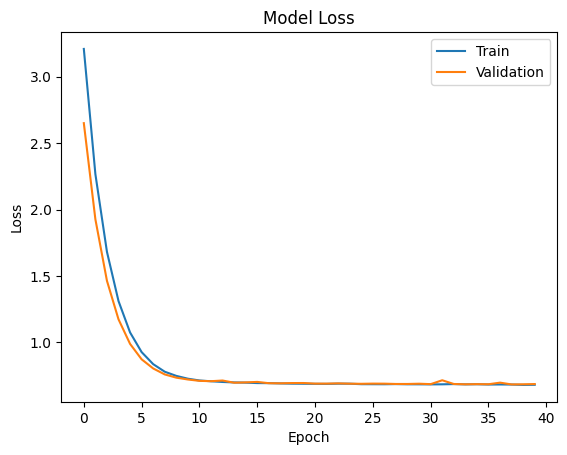

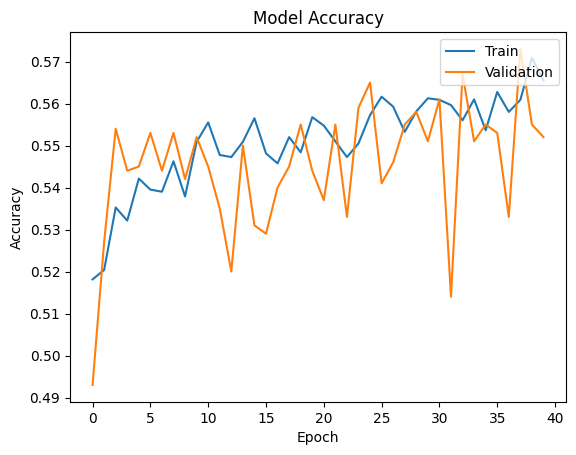

  AUC (ROC): 0.5956
  Accuracy:  0.5730
  Precision: 0.5620
  Recall:    0.7892
  Loss:      0.6839
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-13 05:28:02.288675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6926 - auc: 0.7553 - bin_accuracy: 0.6926 - loss: 0.6250 - precision: 0.6781 - recall: 0.7670


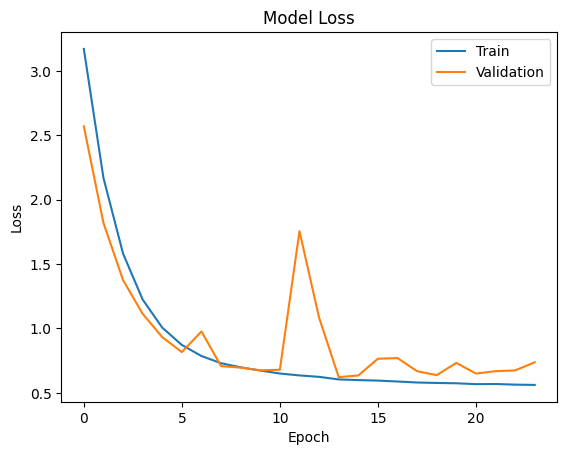

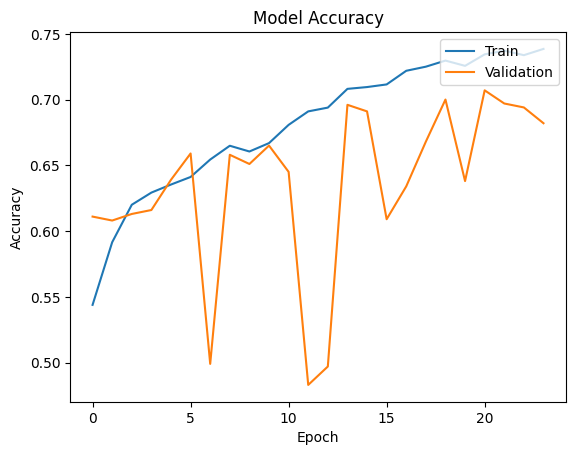

  AUC (ROC): 0.7563
  Accuracy:  0.6960
  Precision: 0.6885
  Recall:    0.7524
  Loss:      0.6222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-13 05:28:14.067156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5984 - auc: 0.6440 - bin_accuracy: 0.5984 - loss: 2.6617 - precision: 0.6384 - recall: 0.5067


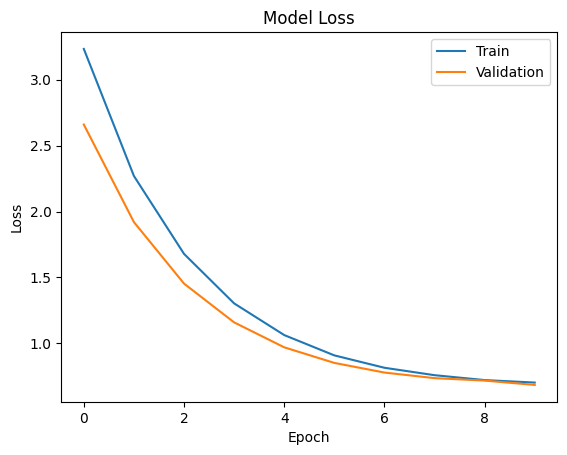

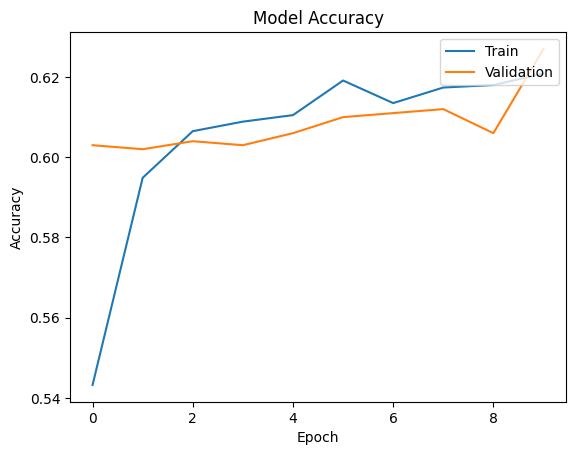

  AUC (ROC): 0.6521
  Accuracy:  0.6030
  Precision: 0.6456
  Recall:    0.5145
  Loss:      2.6594
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-13 05:28:25.864939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5500 - auc: 0.5554 - bin_accuracy: 0.5500 - loss: 2.6887 - precision: 0.5603 - recall: 0.5828


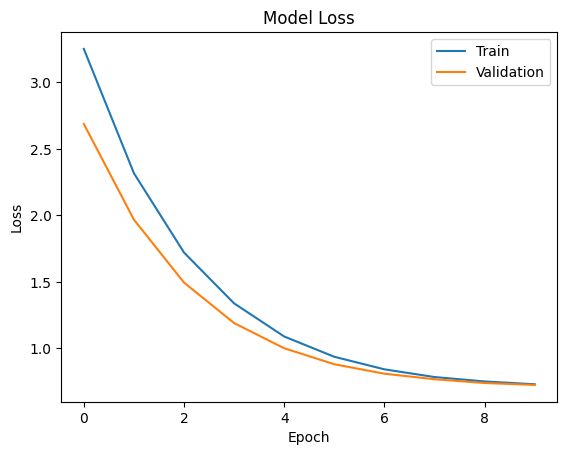

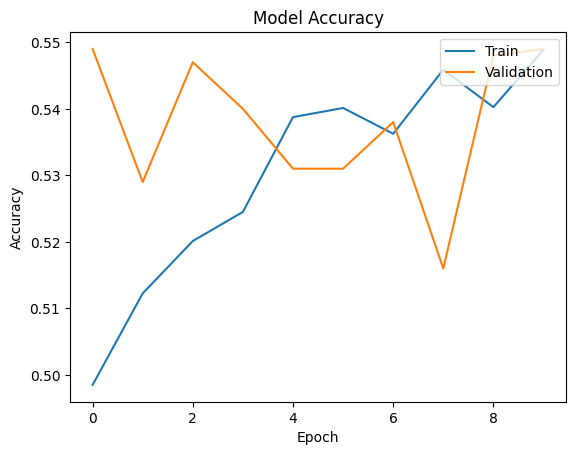

  AUC (ROC): 0.5591
  Accuracy:  0.5490
  Precision: 0.5618
  Recall:    0.5803
  Loss:      2.6876
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-13 05:28:37.308044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5097 - auc: 0.5857 - bin_accuracy: 0.5097 - loss: 3.4491 - precision: 0.5097 - recall: 1.0000


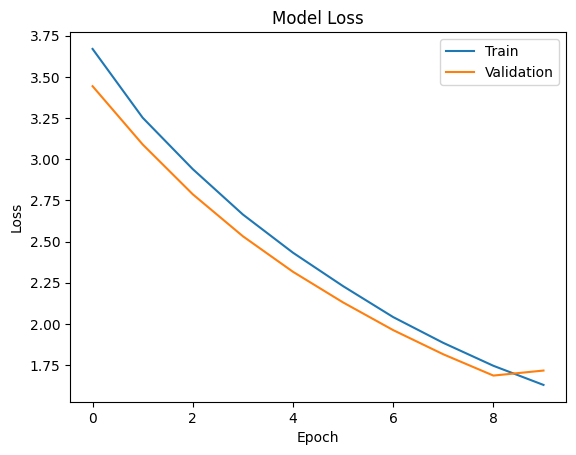

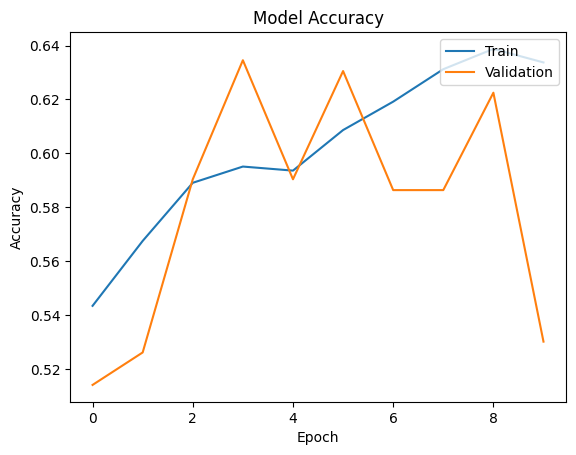

  AUC (ROC): 0.5717
  Accuracy:  0.5141
  Precision: 0.5141
  Recall:    1.0000
  Loss:      3.4436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       121
           1       0.51      1.00      0.68       128

    accuracy                           0.51       249
   macro avg       0.26      0.50      0.34      

2025-04-13 05:28:40.729825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5309 - auc: 0.4667 - bin_accuracy: 0.5309 - loss: 3.8037 - precision: 0.5309 - recall: 1.0000 


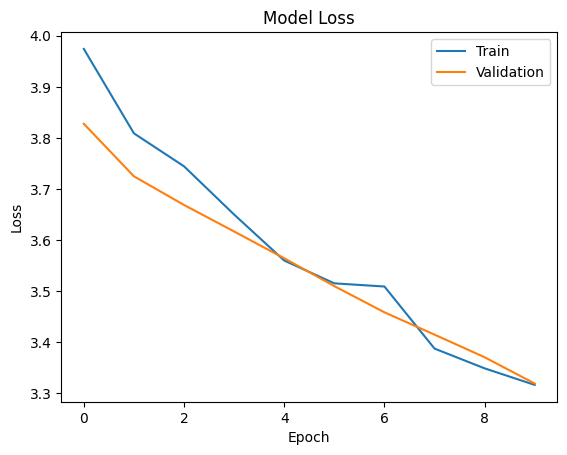

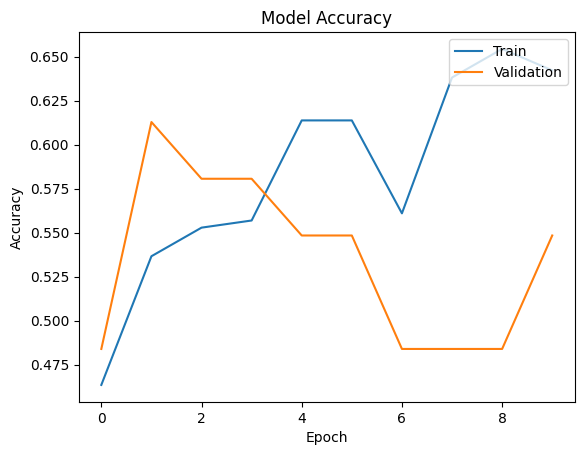

  AUC (ROC): 0.4333
  Accuracy:  0.4839
  Precision: 0.4839
  Recall:    1.0000
  Loss:      3.8275
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.48      1.00      0.65        15

    accuracy                           0.48        31
   macro avg       0.24      0.50      0.33        31
weighted avg       0.23      0.48      0.32        31

 1/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.5000 - auc: 0.6455 - bin_accuracy: 0.5000 - loss: 2.5979 - precision: 0.8000 - recall: 0.3636

2025-04-13 05:28:41.545532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5509 - auc: 0.5963 - bin_accuracy: 0.5509 - loss: 2.6068 - precision: 0.5748 - recall: 0.4927


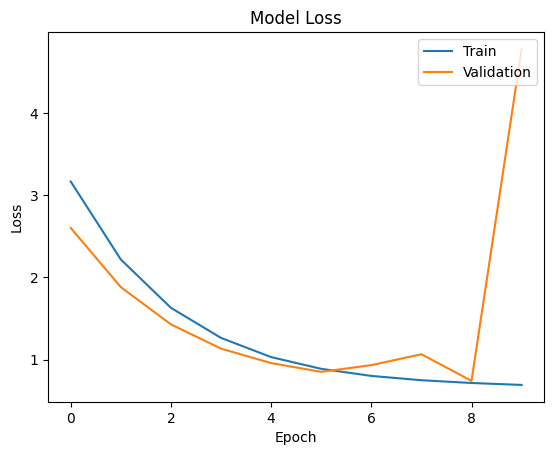

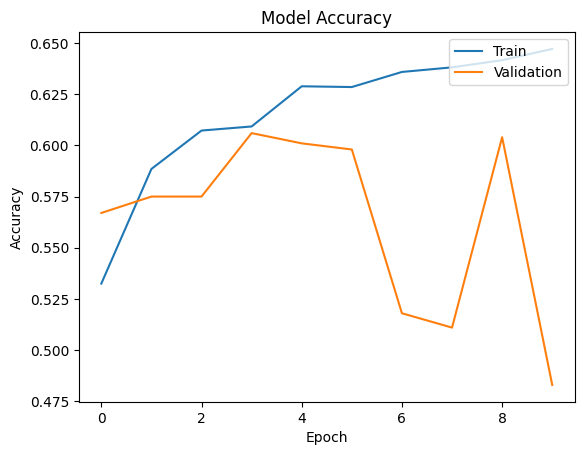

  AUC (ROC): 0.6079
  Accuracy:  0.5670
  Precision: 0.5929
  Recall:    0.5184
  Loss:      2.6046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-13 05:28:55.715183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [371]:
# import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

for i, m_h in enumerate(all_models):
    model, history = m_h
    # Get validation data for the current model
    ds_train, ds_val, ds_test = tasks_datasets[i]

    # Make predictions on the validation set
    results = model.evaluate(ds_val, verbose=1, return_dict=True)

    # plot loss and accuracy
    # history = model.history
    plt.plot(history.history['loss']) # Access the loss from the history object
    plt.plot(history.history['val_loss'])

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Check if 'accuracy' is in the history keys before plotting
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])

        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
    else:
        print("Accuracy not found in history. Skipping accuracy plot.")

    # Evaluate the model
    print(f"  AUC (ROC): {results.get('auc', 'N/A'):.4f}")
    print(f"  Accuracy:  {results.get('accuracy', 'N/A'):.4f}")
    print(f"  Precision: {results.get('precision', 'N/A'):.4f}")
    print(f"  Recall:    {results.get('recall', 'N/A'):.4f}")
    print(f"  Loss:      {results.get('loss', 'N/A'):.4f}")
    # y_pred = (predictions > 0.5).astype(int)
    # accuracy = accuracy_score(y_val, y_pred)
    # precision = precision_score(y_val, y_pred)
    # recall = recall_score(y_val, y_pred)
    # print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
    # print(classification_report(y_val, y_pred))

    # Prepare for classification_report
    y_true = []
    y_pred = []

    # Iterate through the validation dataset to get true labels and predictions
    for x_batch, y_batch in ds_val:
        # Get true labels
        y_true.extend(y_batch.numpy())

        # Make predictions
        predictions = model.predict(x_batch)

        # Determine predicted labels based on the model's output
        if predictions.shape[-1] > 1:  # Multi-class classification
            predicted_labels = np.argmax(predictions, axis=-1)
        else:  # Binary classification (assuming sigmoid activation)
            predicted_labels = (predictions > 0.5).astype(int).flatten()
        y_pred.extend(predicted_labels)

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


## Data Post Processing for Single Tasks Combination 


In [375]:
tasks_with_models = {}
tasks_enumerated = prepared_datasets.keys()
display(tasks_enumerated)

for i, task in enumerate(tasks_enumerated):
    model = all_models[i]
    tasks_with_models[task] = model

# Define the categories and their corresponding labels
category_map = {
    'Infection/Infiltration': ['has_Pneumonia', 'has_Consolidation', 'has_Infiltration'],
    'Fluid Related Issues': ['has_Edema', 'has_Effusion', 'has_Pleural_Thickening'],
    'Lung Structure Issues': ['has_Atelectasis', 'has_Pneumothorax', 'has_Fibrosis', 'has_Emphysema'],
    'Nodule/Mass': ['has_Nodule', 'has_Mass'],
    'Cardiac Issues': ['has_Cardiomegaly'],
    'Hernia': ['has_Hernia'],
    'No Finding': ['has_No Finding']
}

categories = category_map.keys()
display(categories)

dict_keys(['has_Infection/Infiltration', 'has_Fluid Related Issues', 'has_Lung Structure Issues', 'has_Nodule/Mass', 'has_Cardiac Issues', 'has_Hernia', 'has_No Finding'])

dict_keys(['Infection/Infiltration', 'Fluid Related Issues', 'Lung Structure Issues', 'Nodule/Mass', 'Cardiac Issues', 'Hernia', 'No Finding'])

In [399]:
def predict_all_tasks(image_path, tabular_data, resized_images_path, tasks_with_models):
    """
    Predicts the results for all tasks using the provided models, then applies the heuristic.

    Args:
        image_path: Path to the image file.
        tabular_data: A numpy array of tabular data for the image.
        resized_images_path: Path to the directory containing the resized images.
        tasks_with_models: The dictionary containing task names and their corresponding models.

    Returns:
        A NumPy array of predictions for the broader categories.
    """
    # Define threshold for individual task predictions
    THRESHOLD = 0.5

    # Preprocess the image and tabular data
    image_data = np.expand_dims(preprocess_image(os.path.join(resized_images_path, os.path.basename(image_path))), axis=0)
    tabular_data = np.expand_dims(tabular_data, axis=0)
    inputs = (image_data, tabular_data)
    if isinstance(inputs, tuple):
        inputs = {"image_input": inputs[0], "tabular_input": inputs[1]}

    batch_size = inputs["image_input"].shape[0]
    
    # Initialize a dictionary to store individual task predictions
    predictions = {}

    # Get predictions for all individual tasks and store them in the dictionary
    for task, m_h in tasks_with_models.items():
        model, history = m_h
        pred = model.predict(inputs).reshape(batch_size)
        predictions[task] = float(pred)

    return np.array(list(predictions.values()))

In [400]:
def generate_group_labels(df):
    group_labels = []

    for _, row in df.iterrows():
        task_predictions = df[tasks_enumerated]
        task_predictions_dict = row[tasks_enumerated].to_dict()
        group_labels.append(np.array(list(task_predictions_dict.values())))

    return group_labels

### Test with Test data

In [409]:
tasks = prepared_datasets.keys()
# Select a few rows from the test dataset
num_rows_to_pick = 1000 # Adjust the number of rows as needed
rows_to_predict = test_df.sample(n=num_rows_to_pick, random_state=42)
display(rows_to_predict.head())

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding
4457,00013549_002.png,-0.362342,0.587909,0,0,0,0,1,0,0,0
5605,00019087_017.png,1.065656,-0.964004,1,0,1,0,0,0,0,0
4686,00014647_010.png,0.399257,-0.343239,1,0,0,1,0,0,0,0
1055,00010047_000.png,-0.552742,-0.653622,0,0,0,0,0,0,0,1
4813,00015163_001.png,-0.457542,1.705287,1,0,0,0,1,0,0,0


In [ ]:
# Prepare the image paths and tabular data for prediction
image_paths = rows_to_predict['Image Index'].values
tabular_data = rows_to_predict[['Follow-up #', 'Patient Age', 'Patient Gender']].values
# Assuming 'RESIZED_IMAGES_PATH' is defined correctly
resized_images_path = RESIZED_IMAGES_PATH

# Predict labels for each picked image
predictions_results = []
for image_path, tabular_row in zip(image_paths, tabular_data):
    predictions = predict_all_tasks(image_path, tabular_row, resized_images_path, tasks_with_models)
    predictions_results.append(predictions)

rows_to_predict['group_labels'] = generate_group_labels(rows_to_predict)
rows_to_predict['predicted_group_labels'] = predictions_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/tmp/ipykernel_617090/1120432779.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[task] = float(pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

In [411]:
display(rows_to_predict.head())

,Image Index,Follow-up #,Patient Age,Patient Gender,has_Infection/Infiltration,has_Fluid Related Issues,has_Lung Structure Issues,has_Nodule/Mass,has_Cardiac Issues,has_Hernia,has_No Finding,group_labels,predicted_group_labels
4457,00013549_002.png,-0.362342,0.587909,0,0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0]","[0.5562078952789307, 0.24440336227416992, 0.49..."
5605,00019087_017.png,1.065656,-0.964004,1,0,1,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0]","[0.5497235655784607, 0.8173720240592957, 0.585..."
4686,00014647_010.png,0.399257,-0.343239,1,0,0,1,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0]","[0.49886050820350647, 0.5623040199279785, 0.57..."
1055,00010047_000.png,-0.552742,-0.653622,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]","[0.5381428599357605, 0.20930270850658417, 0.42..."
4813,00015163_001.png,-0.457542,1.705287,1,0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0]","[0.5382555723190308, 0.5873086452484131, 0.472..."


In [412]:
from sklearn.metrics import classification_report, accuracy_score

# Assumes categories = ['Cardiac Issues', 'Fluid Related Issues', ..., 'Nodule/Mass']
print("\nClassification Report:\n")
print(f"{'Category':30} {'Precision':>9} {'Recall':>9} {'F1-score':>9} {'Support':>9} {'Accuracy':>9}")

# Extract actual and predicted group labels
true_group_labels = list(rows_to_predict['group_labels'])
pred_group_labels = list(rows_to_predict['predicted_group_labels'])

# Loop over each category
for i, category in enumerate(categories):
    y_true = [row[i] for row in true_group_labels]
    y_pred = [1 if row[i] >= 0.5 else 0 for row in pred_group_labels]  # Apply threshold

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    support = int(report['1']['support'])

    print(f"{category:30} {precision:9.2f} {recall:9.2f} {f1:9.2f} {support:9d} {acc:9.2f}")



Classification Report:

Category                       Precision    Recall  F1-score   Support  Accuracy
Infection/Infiltration              0.29      0.81      0.43       267      0.42
Fluid Related Issues                0.38      0.82      0.52       209      0.69
Lung Structure Issues               0.34      0.48      0.40       259      0.63
Nodule/Mass                         0.24      0.63      0.35       201      0.53
Cardiac Issues                      0.04      1.00      0.08        41      0.04
Hernia                              0.00      1.00      0.01         3      0.00
No Finding                          0.37      0.53      0.44       288      0.60
